# **Análise dos Determinantes da Saúde e Nutrição de Crianças Indígenas**

**Integrantes:** Letícia Ruas, Letícia Rosa, Lívia Rodrigues e Sophia Serafim

### **Introdução:**

Este trabalho realiza uma análise dos dados do Sistema de Informação da Atenção à Saúde Indígena (SIASI), abrangendo o período de 2019 a 2022. O objetivo central é **investigar os padrões de saúde e nutrição infantil, identificando fatores de risco associados à desnutrição e ao déficit de crescimento (baixa estatura)**.

A metodologia adotada segue o seguinte pipeline:
1.  **Engenharia de Dados (ETL):** Consolidação de múltiplas bases fragmentadas (Vigilância Alimentar, Acompanhamento e Pré-natal), tratamento de inconsistências, imputação de dados faltantes e engenharia de novos atributos.
2.  **Análise Exploratória (EDA):** Investigação estatística e visual das variáveis demográficas e nutricionais para compreender o perfil da população atendida.
3.  **Análise Geoespacial:** Mapeamento dos problemas nutricionais predominantes por município, permitindo a identificação de clusters regionais de risco.
4.  **Modelagem Preditiva:** Desenvolvimento de um modelo de *Machine Learning* (Random Forest) para prever o risco de baixa estatura, utilizando técnicas avançadas de seleção de variáveis e otimização de hiperparâmetros.

### **Configuração do Ambiente de Desenvolvimento**

In [1]:
# Instalação de bibliotecas geoespaciais e de visualização
!pip install geopandas geobr plotly rpy2 -q

# Importações
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter

# Análise Geoespacial
import geopandas as gpd
import geobr

# Estatística e Testes de Hipóteses
from scipy import stats
from scipy.stats import chi2_contingency, t
import sys

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Sistema e Arquivos
from google.colab import drive

# Configurações Globais
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Montagem do Google Drive
drive.mount('/content/drive')

# Definição do diretório base
folder_path = '/content/drive/MyDrive/'
print("Ambiente configurado com sucesso.")

#Configuração de Vizualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.9 MB/s eta 0:00:00
Mounted at /content/drive
Ambiente configurado com sucesso.


### **Carregamento dos dados completos**

In [ ]:
vigilancia_alimentar_2019 = pd.read_csv(folder_path + 'projeto_icd/data_base/vigilancia_alimentar_2019.csv', sep=';')
vigilancia_alimentar_2020 = pd.read_csv(folder_path + 'projeto_icd/data_base/vigilancia_alimentar_2020.csv', sep=';')
vigilancia_alimentar_2021 = pd.read_csv(folder_path + 'projeto_icd/data_base/vigilancia_alimentar_2021.csv', sep=';')
vigilancia_alimentar_2022 = pd.read_csv(folder_path + 'projeto_icd/data_base/vigilancia_alimentar_2022.csv', sep=';')

prenatal_2019 = pd.read_csv(folder_path + 'projeto_icd/data_base/prenatal_microdados_2019.csv', sep=';')
prenatal_2020 = pd.read_csv(folder_path + 'projeto_icd/data_base/prenatal_microdados_2020.csv', sep=';')
prenatal_2021 = pd.read_csv(folder_path + 'projeto_icd/data_base/prenatal_microdados_2021.csv', sep=';')
prenatal_2022 = pd.read_csv(folder_path + 'projeto_icd/data_base/prenatal_microdados_2022.csv', sep=';')

acompanhamento_2019 = pd.read_csv(folder_path + 'projeto_icd/data_base/acompanhamento_2019.csv', sep=';')
acompanhamento_2020 = pd.read_csv(folder_path + 'projeto_icd/data_base/acompanhamento_2020.csv', sep=';')
acompanhamento_2021 = pd.read_csv(folder_path + 'projeto_icd/data_base/acompanhamento_2021.csv', sep=';')
acompanhamento_2022 = pd.read_csv(folder_path + 'projeto_icd/data_base/acompanhamento_2022.csv', sep=';')


vigilancia_dfs = {
    2019: vigilancia_alimentar_2019,
    2020: vigilancia_alimentar_2020,
    2021: vigilancia_alimentar_2021,
    2022: vigilancia_alimentar_2022
}

acompanhamento_dfs = {
    2019: acompanhamento_2019,
    2020: acompanhamento_2020,
    2021: acompanhamento_2021,
    2022: acompanhamento_2022
}

prenatal_dfs = {
    2019: prenatal_2019,
    2020: prenatal_2020,
    2021: prenatal_2021,
    2022: prenatal_2022
}

### **Carregamento dos dados consolidados**

In [2]:
colunas_data_criancas = ['dt_atendimento', 'dt_nascimento']
df_criancas = pd.read_csv(folder_path + 'projeto_icd/data_base/dados_consolidados_criancas.csv', parse_dates=colunas_data_criancas)
print("-> DataFrame das crianças carregado!")

colunas_data_prenatal = ['dt_nascimento', 'dt_ultima_menstruacao', 'dt_finalizacao', 'dt_acompanhamento']
df_prenatal = pd.read_csv(folder_path + 'projeto_icd/data_base/dados_consolidados_prenatal.csv', parse_dates=colunas_data_prenatal)
print("-> DataFrame do pré-natal carregado!")

-> DataFrame das crianças carregado!
-> DataFrame do pré-natal carregado!


## **Parte 1**

## **Consolidação e Limpeza Inicial**

In [ ]:
df_vigilancia = pd.concat(vigilancia_dfs).reset_index(level=0).rename(columns={'level_0': 'ano'})
df_acompanhamento = pd.concat(acompanhamento_dfs).reset_index(level=0).rename(columns={'level_0': 'ano'})
df_prenatal = pd.concat(prenatal_dfs).reset_index(level=0).rename(columns={'level_0': 'ano'})

df_vigilancia.reset_index(drop=True, inplace=True)
df_acompanhamento.reset_index(drop=True, inplace=True)
df_prenatal.reset_index(drop=True, inplace=True)

### **Diagnóstico**

In [ ]:
# Resumo de cada df
df_vigilancia.info()
print('-' * 80)
df_acompanhamento.info()
print('-' * 80)
df_prenatal.info()

def diagnostico_df(df, nome="DataFrame"):
    print("="*80)
    print(f"Diagnóstico do {nome}")
    print("="*80)

    print(f"Dimensão: {df.shape[0]:,} linhas × {df.shape[1]} colunas\n")

    print("Tipos de dados:")
    print(df.dtypes.value_counts(), "\n")

    print("Valores ausentes (top 10):")
    missing = df.isnull().sum().sort_values(ascending=False)
    missing = missing[missing > 0]
    if not missing.empty:
        print((missing / len(df) * 100).round(2).astype(str) + " %")
    else:
        print("Nenhum valor ausente.\n")

    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        print("\nEstatísticas numéricas:")
        print(df[num_cols].describe(percentiles=[.01, .25, .5, .75, .99]).T)

        print("\nPossíveis outliers (limite pelo IQR):")
        for col in num_cols:
            q1, q3 = df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            outliers = ((df[col] < lower) | (df[col] > upper)).sum()
            if outliers > 0:
                print(f" - {col}: {outliers:,} outliers")
    else:
        print("\nNenhuma coluna numérica encontrada.")

    cat_cols = df.select_dtypes(include=["object"]).columns
    if len(cat_cols) > 0:
        print("\nEstatísticas categóricas:")
        for col in cat_cols[:5]:
            print(f"\nColuna: {col}")
            print("Nº de categorias únicas:", df[col].nunique())
            print("Top valores:")
            print(df[col].value_counts(dropna=False).head(5))
    print("\n\n")

# Rodar diagnóstico para os três dfs
diagnostico_df(df_vigilancia, "df_vigilancia")
diagnostico_df(df_acompanhamento, "df_acompanhamento")
diagnostico_df(df_prenatal, "df_prenatal")

**Diagnóstico:**
* Colunas que deveriam ser datas, estão sendo tratadas como texto!
* No df_vigilancia, as colunas nu_peso e nu_altura também são object.
* Dados Nulos:
    *   df_vigilancia: Apenas tipo_aleitamento tem alguns nulos. É uma    quantidade pequena e manejável.

    *   df_acompanhamento: faixa_etaria_atend tem uma quantidade considerável de nulos.
    
    * df_prenatal: É o que mais sofre com dados faltantes, especialmente nas colunas sobre o profissional (ds_cbo_familia, ds_cbo_ocupacao) e o motivo da finalização da gestação (st_motivo_finalizacao).



In [ ]:
def limpar_dataframe(df, nome="DataFrame"):
    print(f"\nLimpando {nome}")

    df_clean = df.copy()

    # 1. Converter datas automaticamente
    for col in df_clean.columns:
        if col.startswith("dt_"):
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")
            except Exception:
                print(f"Problema ao converter {col} para datetime")

    # 2. Reclassificar IDs e códigos para string
    for col in df_clean.columns:
        if col.startswith(("co_", "cod_", "nu_")):
            df_clean[col] = df_clean[col].astype("string")

    # 3. Padronizar categorias sujas
    for col in df_clean.select_dtypes(include="object").columns:
        df_clean[col] = df_clean[col].replace({
            "A qualificar para validação": np.nan,
            "FORA DE TERRA INDÍGENA SITUADA EM ÁREA RURAL": "FORA_TERRA_RURAL",
            "FORA DE TERRA INDÍGENA": "FORA_TERRA"
        })

    # 4. Remover espaços extras e padronizar maiúsculas em categóricas
    for col in df_clean.select_dtypes(include="object").columns:
        df_clean[col] = df_clean[col].str.strip().str.upper()

    print(f"{nome} limpo. Dimensão final: {df_clean.shape[0]:,} linhas × {df_clean.shape[1]} colunas")
    return df_clean


# Aplicar nos três DataFrames
df_vigilancia_clean = limpar_dataframe(df_vigilancia, "df_vigilancia")
df_acompanhamento_clean = limpar_dataframe(df_acompanhamento, "df_acompanhamento")
df_prenatal_clean = limpar_dataframe(df_prenatal, "df_prenatal")

In [ ]:
# Detecta outliers usando IQR
def marcar_outliers(df, col):
    if pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        df[col + "_outlier"] = ((df[col] < lim_inf) | (df[col] > lim_sup))
    return df

# Imputa valores ausentes em colunas categóricas com "DESCONHECIDO"
def imputar_categorias(df, cols):
    for col in cols:
        df[col] = df[col].fillna("DESCONHECIDO")
    return df

# Imputa valores ausentes em colunas numéricas com mediana
def imputar_numericos(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].median())
    return df

In [ ]:
def limpeza_avancada(df, nome="DataFrame"):
    print(f"\nLimpeza avançada: {nome}")
    df_clean = df.copy()

    # 1. Marcar outliers em colunas numéricas importantes
    col_num = df_clean.select_dtypes(include=np.number).columns.tolist()
    for col in col_num:
        df_clean = marcar_outliers(df_clean, col)

    # 2. Tratar valores ausentes críticos
    col_categ = df_clean.select_dtypes(include="object").columns.tolist()
    df_clean = imputar_categorias(df_clean, col_categ)

    col_num = df_clean.select_dtypes(include=np.number).columns.tolist()
    df_clean = imputar_numericos(df_clean, col_num)

    print(f"Limpeza avançada concluída para {nome}. Dimensão final: {df_clean.shape}")
    return df_clean

In [ ]:
df_vigilancia_final = limpeza_avancada(df_vigilancia_clean, "df_vigilancia")
df_acompanhamento_final = limpeza_avancada(df_acompanhamento_clean, "df_acompanhamento")
df_prenatal_final = limpeza_avancada(df_prenatal_clean, "df_prenatal")

In [ ]:
# O valor "SEM INFORMÇÃO" também será substituido por DESCONHECIDO, para uniformidade
valores_para_substituir = 'SEM INFORMAÇÃO'

lista_dfs = [df_vigilancia_final, df_acompanhamento_final, df_prenatal_final]

for df in lista_dfs:
  df.replace(valores_para_substituir, 'DESCONHECIDO', inplace=True)


In [ ]:
 #listar as colunas com NaN

lista_de_dfs = [df_vigilancia_final, df_acompanhamento_final, df_prenatal_final]
lista_de_nomes = ['df_vigilancia_final', 'df_acompanhamento_final', 'df_prenatal_final']

for df, df_name in zip(lista_de_dfs, lista_de_nomes):
    print("="*50)
    print(f"Analisando Colunas com NaNs no DataFrame: '{df_name}'")
    print("="*50)

    # Encontra as colunas que contêm QUALQUER valor NaN e transforma em uma lista
    colunas_com_nan = df.columns[df.isnull().any()].tolist()

    if colunas_com_nan:
        print(f"As seguintes colunas contêm valores NaN:")
        print(f"  -> {colunas_com_nan}")
    else:
        print("Ótimo! Nenhuma coluna com valores NaN foi encontrada.")

    print("\n")

In [ ]:
df_acompanhamento_final['co_cbo_ocupacao'].unique()

In [ ]:
"As colunas que mantém os NA são de código -  não faz sentido pegar a mediana"

lista_dfs = [df_vigilancia_final, df_acompanhamento_final, df_prenatal_final]

print("--- Preenchendo valores NaN com 'DESCONHECIDO' usando .fillna() ---")
for df in lista_dfs:
  df.fillna('DESCONHECIDO', inplace=True)

In [ ]:
df_acompanhamento_final['co_cbo_ocupacao'].unique()

In [ ]:
def analise_colunas(df):
  for column in df.columns:
    print(column)
    print(df[column].unique())

for df,df_name in zip(
                [df_vigilancia_final, df_acompanhamento_final, df_prenatal_final],
                 ['df_vigilancia_final', 'df_acompanhamento_final', 'df_prenatal_final']):
  print(df_name)
  analise_colunas(df)

### **Conversão de Tipos de Dados (Type Casting)**

In [ ]:
def limpar_e_tipar_dataframes(lista_de_dfs, lista_de_nomes):
    """
    Aplica um conjunto de regras de limpeza e conversão de tipos
    a uma lista de DataFrames.
    """
    for df, nome_df in zip(lista_de_dfs, lista_de_nomes):
        print("="*60)
        print(f"Processando o DataFrame: '{nome_df}'")
        print("="*60)

        for coluna in df.columns:
            if coluna in ['nu_peso', 'nu_altura']:
                # Verifica se a coluna é do tipo texto antes de tentar substituir
                if pd.api.types.is_string_dtype(df[coluna]):
                    print(f"  - Convertendo coluna numérica '{coluna}' para float...")
                    # Substitui vírgula por ponto e converte para numérico
                    # errors='coerce' transforma valores inválidos em NaN
                    df[coluna] = pd.to_numeric(df[coluna].str.replace(',', '.'), errors='coerce')

            elif coluna.startswith('dt_'):
                # Verifica se a coluna já não é do tipo datetime
                if not pd.api.types.is_datetime64_any_dtype(df[coluna]):
                    print(f"  - Convertendo coluna de data '{coluna}' para datetime...")
                    # errors='coerce' transforma datas inválidas em NaT (Not a Time)
                    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')

            elif pd.api.types.is_object_dtype(df[coluna]):
                num_unicos = df[coluna].nunique()
                # Heurística: converte se tiver menos de 50 valores únicos
                # e se o número de únicos for menor que 50% do total de linhas.
                # isso evita converter colunas de ID.
                if num_unicos < 50 and num_unicos / len(df) < 0.5:
                    print(f"  - Convertendo coluna de texto '{coluna}' para category...")
                    df[coluna] = df[coluna].astype('category')
        print("Processamento concluído.\n")

dataframes = [df_vigilancia_final, df_acompanhamento_final, df_prenatal_final]
nomes_dfs = ['df_vigilancia_final', 'df_acompanhamento_final', 'df_prenatal_final']

limpar_e_tipar_dataframes(dataframes, nomes_dfs)

print("="*60)
print("VERIFICAÇÃO FINAL DOS TIPOS DE DADOS (dtypes)")
print("="*60)
for df, nome_df in zip(dataframes, nomes_dfs):
    print(f"\n--- {nome_df}.info() ---")
    df.info()


### **Consolidação dos DataFrames**

A partir daqui, importante citar que devemos usar os seguintes data frames, que já estão limpos e consolidados com os tipos corretos:

`df_vigilancia_final`, `df_acompanhamento_final`, `df_prenatal_final`

In [ ]:
# Revisão geral dos dfs
print("--- df_vigilancia_final ---")
df_vigilancia_final.info()
print("\nPrimeiras linhas:")
print(df_vigilancia_final.head())
print("\n")

print("--- df_acompanhamento_final ---")
df_acompanhamento_final.info()
print("\nPrimeiras linhas:")
print(df_acompanhamento_final.head())
print("\n")

print("--- df_prenatal_final ---")
df_prenatal_final.info()
print("\nPrimeiras linhas:")
print(df_prenatal_final.head())

# Importante citar que enquanto nos 2 primeiros co_indio_desidentificado é um
# codigo para a criança, no de pre-natal é um codigo para a mãe, e não estão
# relacionados diretamente

In [ ]:
# Consolidação dos DataFrames
# Chaves de junção: identificador do indivíduo e a data do atendimento.
chaves = ['co_indio_desidentificado', 'dt_atendimento']

# Realizando a junção 'outer' para não perder registros de nenhum dos lados.
df_consolidado = pd.merge(
    df_vigilancia_final,
    df_acompanhamento_final,
    on=chaves,
    how='outer',
    suffixes=('_vigilancia', '_acompanhamento') # Adiciona sufixos para colunas com mesmo nome (exceto as chaves)
)

print("--- Informações do DataFrame Consolidado ---")
df_consolidado.info()

print("\n--- Primeiras linhas do DataFrame Consolidado ---")
print(df_consolidado.head())

print(f"\nShape do df_vigilancia_final: {df_vigilancia_final.shape}")
print(f"Shape do df_acompanhamento_final: {df_acompanhamento_final.shape}")
print(f"Shape do df_consolidado: {df_consolidado.shape}")

### **Engenharia de Variáveis**

In [ ]:
# Primeiro, vamos unificar as colunas de data de nascimento que foram duplicadas no merge.
# O método 'bfill' preenche os nulos de uma coluna com o valor da próxima coluna (no eixo 1).
df_consolidado['dt_nascimento'] = df_consolidado['dt_nascimento_vigilancia'].bfill(axis=0)

# Calcular a idade em anos
# A diferença entre as datas resulta em um 'Timedelta'. Dividimos pelo número de dias em um ano.
# Usar 365.25 dias ajuda a contabilizar os anos bissextos de forma aproximada.
dias_no_ano = 365.25
df_consolidado['idade_anos'] = (df_consolidado['dt_atendimento'] - df_consolidado['dt_nascimento']).dt.days / dias_no_ano

print("\n--- Verificando a nova coluna 'idade_anos' ---")
print(df_consolidado[['dt_nascimento', 'dt_atendimento', 'idade_anos']].head())

print("Iniciando a unificação de colunas duplicadas...")

colunas_para_unificar = [
    'ano', 'dsei_gestao', 'co_dsei_gestao', 'cod_polo_base', 'ds_polo_base',
    'no_terra_indigena', 'co_municipio_ibge', 'no_municipio', 'sg_uf',
    'dt_nascimento', 'tp_sexo', 'mes_atend', 'ano_atend', 'co_profissional',
    'co_cbo_familia', 'ds_cbo_familia', 'co_ocupacao', 'ds_cbo_ocupacao',
    'nu_peso', 'nu_altura', 'idade_meses_atend'
]

for col in colunas_para_unificar:
    col_vig = f'{col}_vigilancia'
    col_acomp = f'{col}_acompanhamento'

    # Verifica se as colunas com sufixo existem no DataFrame
    if col_vig in df_consolidado.columns and col_acomp in df_consolidado.columns:
        # Usa combine_first para preencher NaNs de uma coluna com valores da outra
        df_consolidado[col] = df_consolidado[col_vig].combine_first(df_consolidado[col_acomp])
        # Remove as colunas antigas com sufixo
        df_consolidado.drop(columns=[col_vig, col_acomp], inplace=True)
        print(f" -> Coluna '{col}' unificada.")

# Tratamento para colunas que só existem em um dos DFs originais
# Renomeando para um nome padrão sem sufixo
df_consolidado.rename(columns={
    'ds_peso_idade_vigilancia': 'ds_peso_idade',
    'ds_estatura_idade_vigilancia': 'ds_estatura_idade',
    'ds_imc_idade_vigilancia': 'ds_imc_idade',
    'tipo_aleitamento_vigilancia': 'tipo_aleitamento'
}, inplace=True)
print(" -> Colunas de vigilância renomeadas.")

print("Corrigindo a criação da variável 'desnutricao'...")
categorias_desnutricao_correta = ['MUITO BAIXO PESO PARA A IDADE', 'BAIXO PESO PARA A IDADE']

# Recria a coluna 'desnutricao' com a lógica certa
# 1 se ds_peso_idade estiver na lista, 0 caso contrário. np.nan se o dado for nulo.
df_consolidado['desnutricao'] = np.where(
    df_consolidado['ds_peso_idade'].isin(categorias_desnutricao_correta), 1,
    np.where(df_consolidado['ds_peso_idade'].notna(), 0, np.nan)
)

print(" -> Variável 'desnutricao' corrigida.")
print("\nNova verificação da coluna:")
# Vamos usar o crosstab que é ainda mais claro para verificação
print(pd.crosstab(df_consolidado['ds_peso_idade'], df_consolidado['desnutricao'], dropna=False))

print("\nDataFrame final após engenharia de variáveis:")
df_consolidado.info()

print("Salvando o DataFrame das crianças (vigilância + acompanhamento)...")
df_consolidado.to_csv(folder_path + 'projeto_icd/data_base/dados_consolidados_criancas.csv', index=False)
print("-> Arquivo 'dados_consolidados_criancas.csv' salvo com sucesso!")

print("\nSalvando o DataFrame do pré-natal...")
df_prenatal_final.to_csv(folder_path + 'projeto_icd/data_base/dados_consolidados_prenatal.csv', index=False)
print("-> Arquivo 'dados_consolidados_prenatal.csv' salvo com sucesso!")

# **Parte 2**

### **Perguntas Exploratórias Adicionais**

**Qual a prevalência dos principais diagnósticos nutricionais?**

Prevalência dos Diagnósticos Nutricionais


/tmp/ipython-input-3052338401.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_criancas, y='ds_peso_idade', ax=axes[0],
/tmp/ipython-input-3052338401.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_criancas, y='ds_estatura_idade', ax=axes[1],


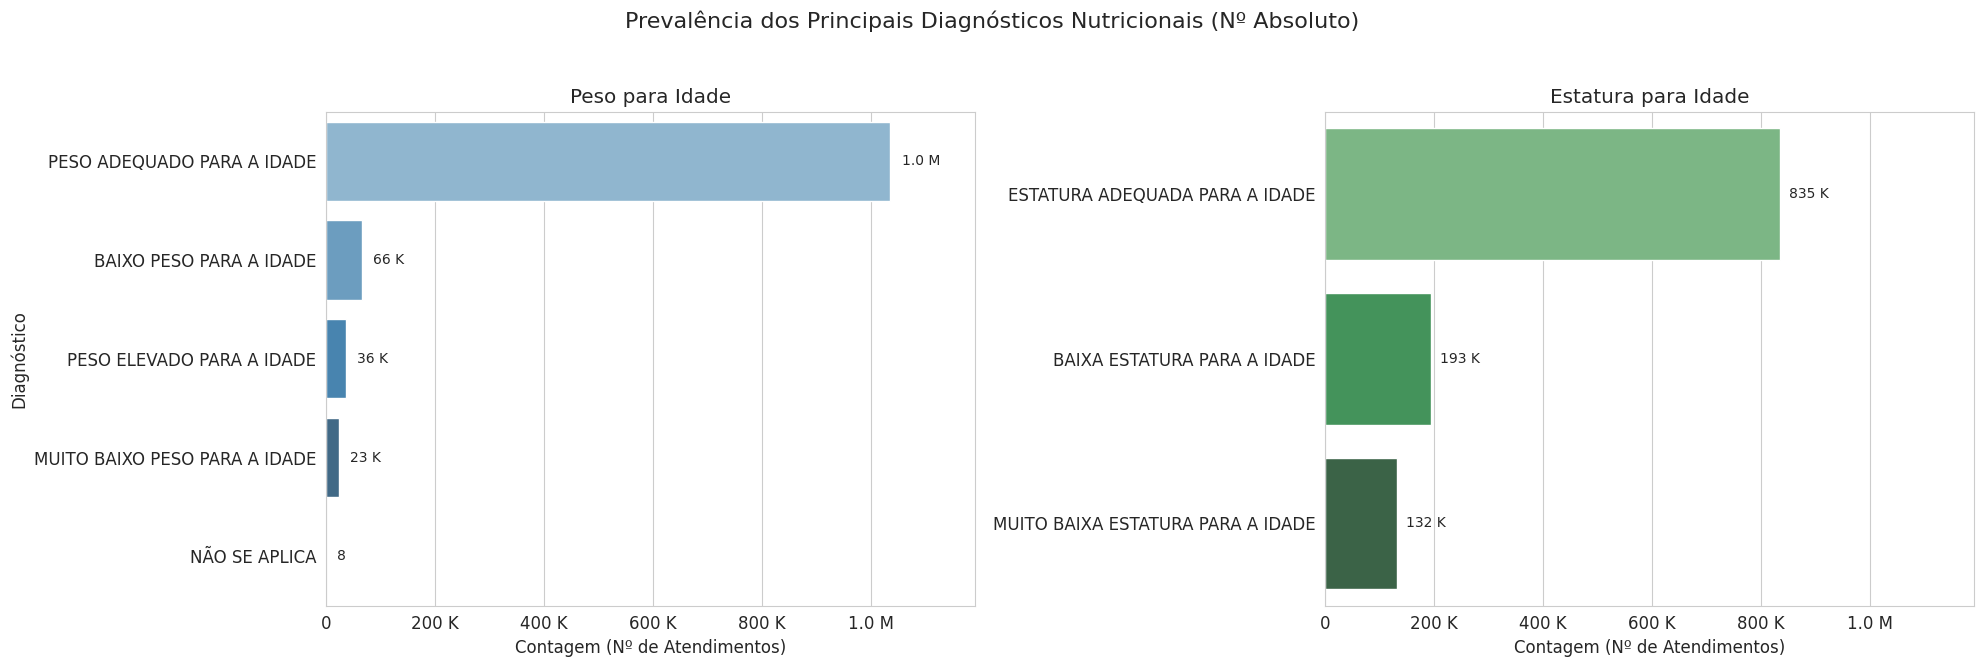


Valores Percentuais (Peso para Idade):
ds_peso_idade
PESO ADEQUADO PARA A IDADE       67.36
NaN                              24.51
BAIXO PESO PARA A IDADE           4.26
PESO ELEVADO PARA A IDADE         2.35
MUITO BAIXO PESO PARA A IDADE     1.51
NÃO SE APLICA                     0.00
Name: proportion, dtype: float64

Valores Percentuais (Estatura para Idade):
ds_estatura_idade
ESTATURA ADEQUADA PARA A IDADE       54.29
NaN                                  24.51
BAIXA ESTATURA PARA A IDADE          12.58
MUITO BAIXA ESTATURA PARA A IDADE     8.61
Name: proportion, dtype: float64


In [ ]:
def human_readable_formatter(x, pos):
    """
    Formata números grandes em uma string legível (ex: 1.5M, 250K).
    """
    if x >= 1_000_000:
        # Formata como '1.0 M', '2.5 M', etc.
        return f'{x / 1_000_000:.1f} M'
    if x >= 1_000:
        # Formata como '250 K', '500 K' (sem casas decimais)
        return f'{x / 1_000:.0f} K'
    # Retorna o número como inteiro se for menor que 1000
    return f'{x:.0f}'

formatter = FuncFormatter(human_readable_formatter)

print("Prevalência dos Diagnósticos Nutricionais")

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Prevalência dos Principais Diagnósticos Nutricionais (Nº Absoluto)', fontsize=16)

#Gráfico 1: Peso para Idade
sns.countplot(data=df_criancas, y='ds_peso_idade', ax=axes[0],
              order=df_criancas['ds_peso_idade'].value_counts().index, palette='Blues_d')
axes[0].set_title('Peso para Idade')
axes[0].set_xlabel('Contagem (Nº de Atendimentos)')
axes[0].set_ylabel('Diagnóstico')
axes[0].xaxis.set_major_formatter(formatter)

#Gráfico 2: Estatura para Idade
sns.countplot(data=df_criancas, y='ds_estatura_idade', ax=axes[1],
              order=df_criancas['ds_estatura_idade'].value_counts().index, palette='Greens_d')
axes[1].set_title('Estatura para Idade')
axes[1].set_xlabel('Contagem (Nº de Atendimentos)')
axes[1].set_ylabel('')
axes[1].xaxis.set_major_formatter(formatter)

#Adicionar Rótulos de Dados
def add_labels_countplot(ax):
    max_val = max(p.get_width() for p in ax.patches)
    lim_buffer = max_val * 0.02

    for p in ax.patches:
        width = p.get_width()
        label_text = human_readable_formatter(width, None)

        ax.text(width + lim_buffer, # Posição X
                p.get_y() + p.get_height() / 2., # Posição Y
                label_text,
                ha='left',
                va='center',
                fontsize=10)

add_labels_countplot(axes[0])
add_labels_countplot(axes[1])

# Ajustar os limites do eixo X para dar espaço aos rótulos
try:
    max_peso = df_criancas['ds_peso_idade'].value_counts().max()
    max_estatura = df_criancas['ds_estatura_idade'].value_counts().max()
    common_xlim = max(max_peso, max_estatura) * 1.15
    axes[0].set_xlim(0, common_xlim)
    axes[1].set_xlim(0, common_xlim)
except Exception:
    pass

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout
plt.savefig("prevalencia_diagnosticos_formatado.png") # Salva a imagem
plt.show()

print("\nValores Percentuais (Peso para Idade):")
print((df_criancas['ds_peso_idade'].value_counts(normalize=True, dropna=False) * 100).round(2))

print("\nValores Percentuais (Estatura para Idade):")
print((df_criancas['ds_estatura_idade'].value_counts(normalize=True, dropna=False) * 100).round(2))


--- 2. Distribuição de Idades e Sexo ---


/tmp/ipython-input-3174759802.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(



Estatísticas da Idade (APENAS anos >= 0):
count    1.517351e+06
mean     1.556861e+00
std      1.444946e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      7.000000e+00
Name: idade_anos_completos, dtype: float64

Contagem por Sexo (APENAS amostra com Idade >= 0):
tp_sexo
M    774137
F    743214
Name: count, dtype: int64


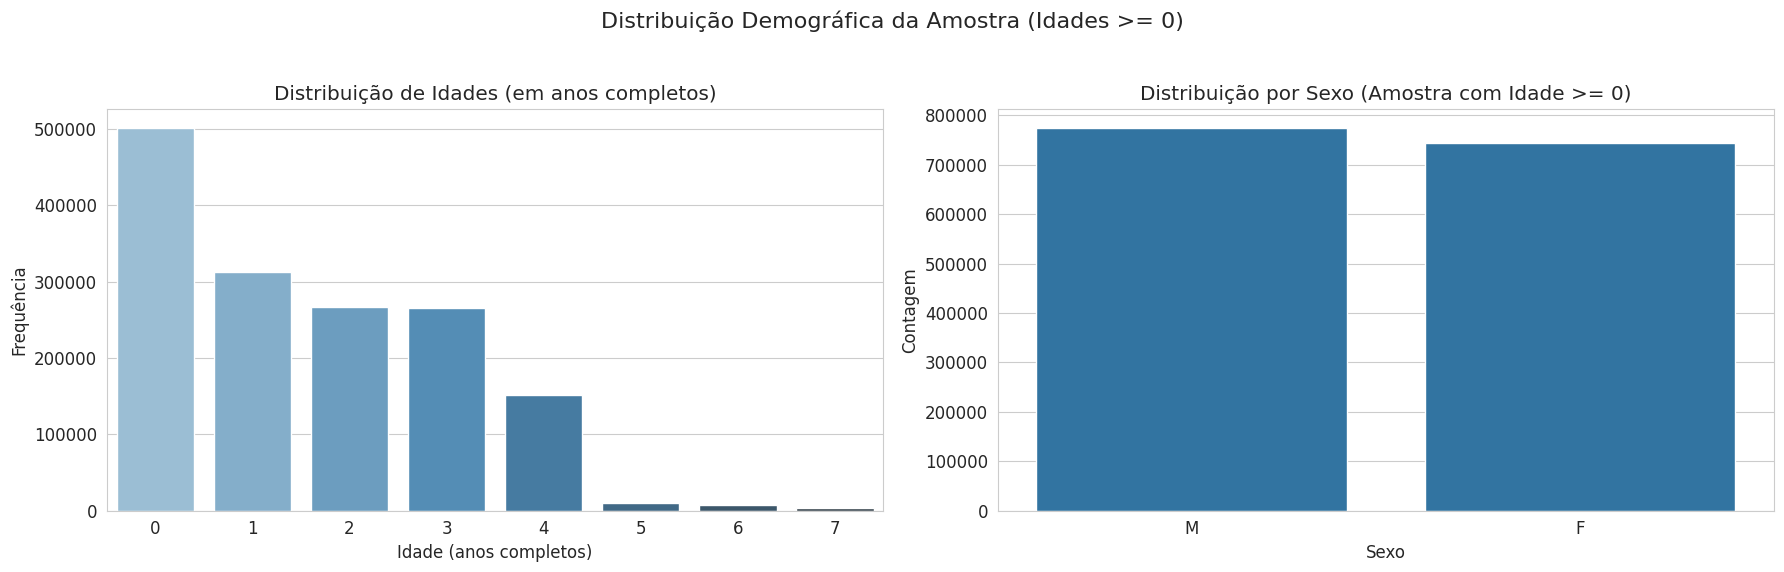

In [ ]:
print("\n--- 2. Distribuição de Idades e Sexo ---")
# Criar DF filtrado
df_plotar_demo = df_criancas[df_criancas['idade_anos'] >= 0].copy()

#    Usamos np.floor() para "arredondar para baixo" (ex: 1.9 anos vira 1)
df_plotar_demo['idade_anos_completos'] = df_plotar_demo['idade_anos'].apply(np.floor).astype(int)



# Criar uma figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Título atualizado para refletir os dados limpos
fig.suptitle('Distribuição Demográfica da Amostra (Idades >= 0)', fontsize=16)

# Gráfico 1: Contagem de Idades
#    Usamos sns.countplot para ter uma barra discreta para cada ano
sns.countplot(
    data=df_plotar_demo,
    x='idade_anos_completos',
    ax=axes[0],
    palette='Blues_d'
)
axes[0].set_title('Distribuição de Idades (em anos completos)')
axes[0].set_xlabel('Idade (anos completos)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlim(left=-0.5)

# Gráfico 2: Contagem de Sexo
try:
    order_sexo = df_plotar_demo['tp_sexo'].value_counts().index
except KeyError:
    order_sexo = None

sns.countplot(
    data=df_plotar_demo,
    x='tp_sexo',
    ax=axes[1],
    order=order_sexo
)
axes[1].set_title('Distribuição por Sexo (Amostra com Idade >= 0)')
axes[1].set_xlabel('Sexo')
axes[1].set_ylabel('Contagem')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("distribuicao_demografica_corrigida.png")

# --- 4. Imprimir estatísticas (Usando os dados limpos) ---
print("\nEstatísticas da Idade (APENAS anos >= 0):")
# Descreve a coluna de inteiros que foi plotada
print(df_plotar_demo['idade_anos_completos'].describe())

print("\nContagem por Sexo (APENAS amostra com Idade >= 0):")
# Conta o sexo no DataFrame filtrado
try:
    print(df_plotar_demo['tp_sexo'].value_counts(dropna=False))
except KeyError:
    print("Coluna 'tp_sexo' não encontrada nos dados de exemplo.")

**Como se distribuem as idades e o sexo na amostra?**

**Quais são os tipos de aleitamento mais comuns?**

 Tipos de Aleitamento Mais Comuns (Filtro: Crianças de 0 a 2 anos) ---

Analisando 813,704 atendimentos de crianças no primeiro ano de vida (Idade >= 0 e < 1).
Gráfico 'tipos_aleitamento_0a1_ano.png' salvo.


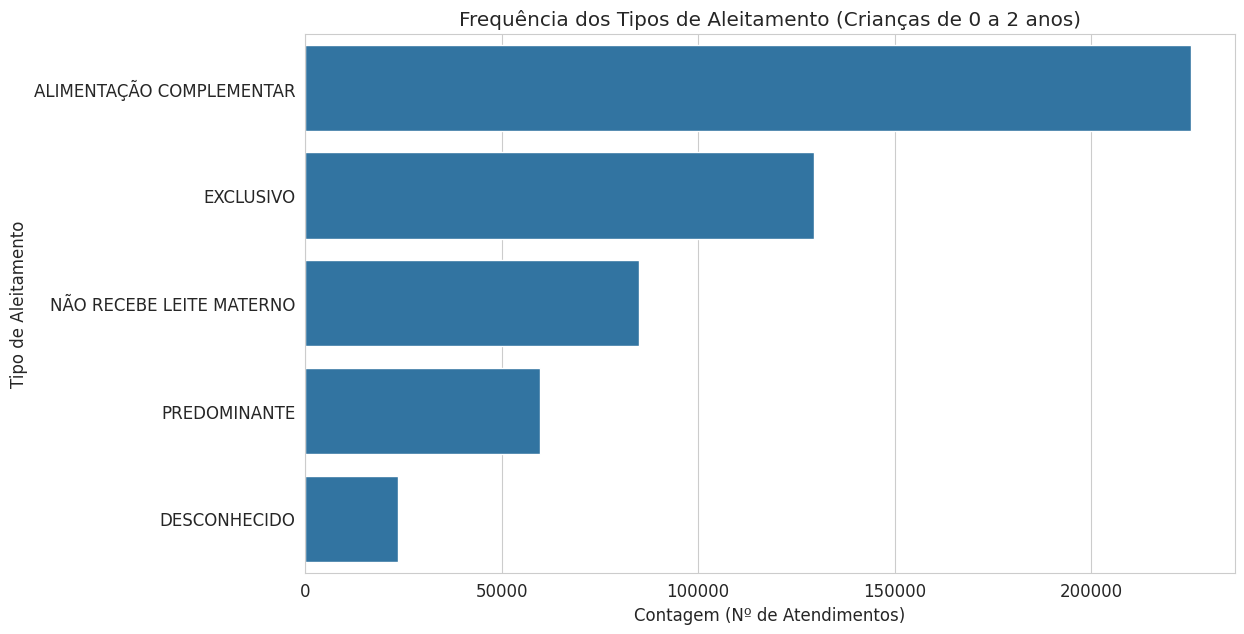


Frequência por Tipo de Aleitamento (em %) - (Crianças de 0 a 2 anos):
tipo_aleitamento
NaN                         35.75
ALIMENTAÇÃO COMPLEMENTAR    27.68
EXCLUSIVO                   15.90
NÃO RECEBE LEITE MATERNO    10.43
PREDOMINANTE                 7.34
DESCONHECIDO                 2.89
Name: proportion, dtype: float64


In [ ]:
print(" Tipos de Aleitamento Mais Comuns (Filtro: Crianças de 0 a 2 anos) ---")


try:
    df_aleitamento_0a1 = df_criancas[
        (df_criancas['idade_anos'] >= 0) &
        (df_criancas['idade_anos'] < 2)
    ].copy()

    print(f"\nAnalisando {len(df_aleitamento_0a1):,} atendimentos de crianças no primeiro ano de vida (Idade >= 0 e < 1).")

    plt.figure(figsize=(12, 7))

    sns.countplot(
        data=df_aleitamento_0a1,
        y='tipo_aleitamento',
        order=df_aleitamento_0a1['tipo_aleitamento'].value_counts().index
    )

    plt.title('Frequência dos Tipos de Aleitamento (Crianças de 0 a 2 anos)')
    plt.xlabel('Contagem (Nº de Atendimentos)')
    plt.ylabel('Tipo de Aleitamento')

    plt.savefig("tipos_aleitamento_0a1_ano.png")
    print("Gráfico 'tipos_aleitamento_0a1_ano.png' salvo.")
    plt.show()

    print("\nFrequência por Tipo de Aleitamento (em %) - (Crianças de 0 a 2 anos):")
    print((df_aleitamento_0a1['tipo_aleitamento'].value_counts(normalize=True, dropna=False) * 100).round(2))

except KeyError as e:
    print(f"\nErro: Coluna {e} não encontrada. Não foi possível executar a filtragem.")
except NameError:
    print("\nErro: DataFrame 'df_criancas' não encontrado. Carregue os dados primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

**Quais os profissionais de saúde (ds_cbo_familia) que mais realizam atendimentos?**


--- 4. Profissionais de Saúde que Mais Realizam Atendimentos ---


/tmp/ipython-input-2197213036.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_profissionais.values, y=top_10_profissionais.index, palette='viridis')


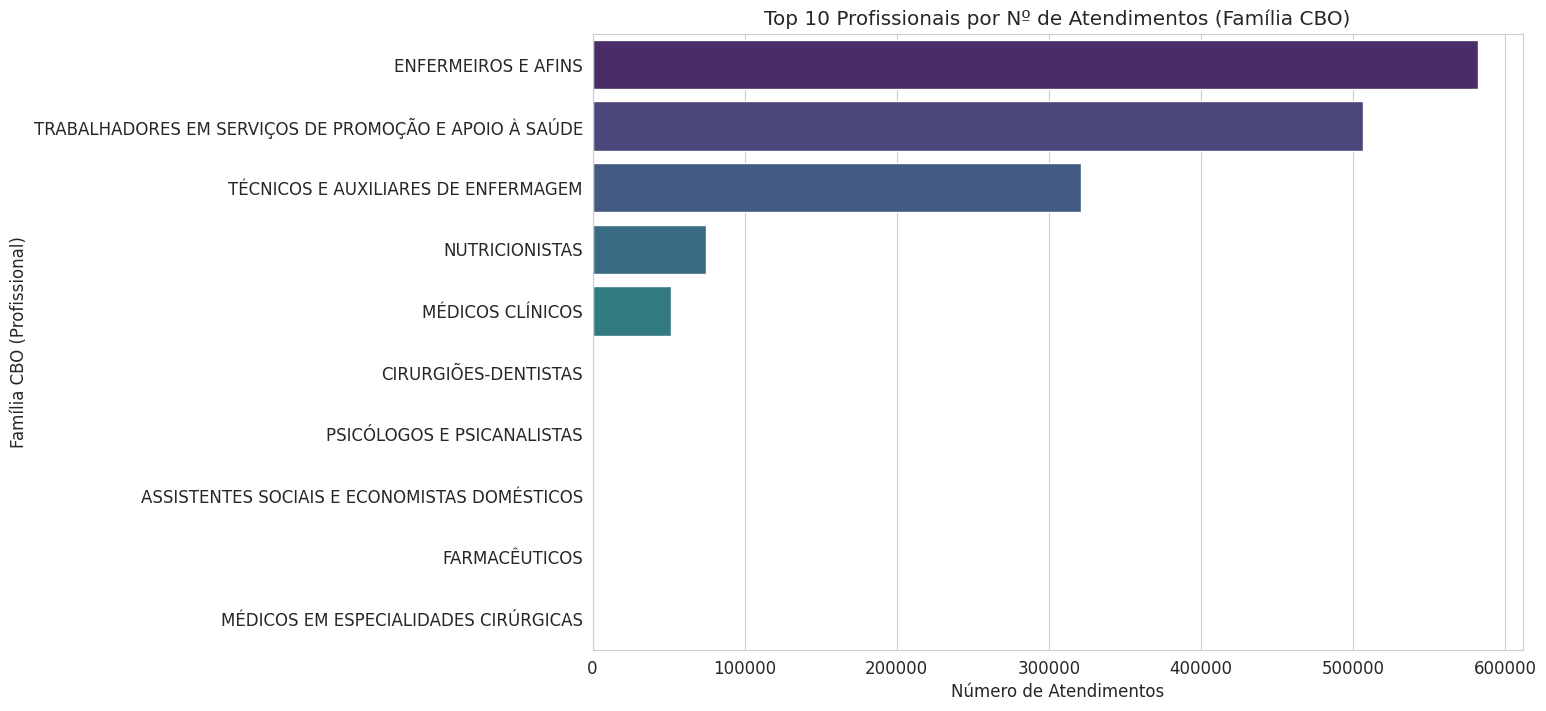


Top 10 Profissionais (ds_cbo_familia), excluindo 'DESCONHECIDO':
ds_cbo_familia
ENFERMEIROS E AFINS                                      582235
TRABALHADORES EM SERVIÇOS DE PROMOÇÃO E APOIO À SAÚDE    506589
TÉCNICOS E AUXILIARES DE ENFERMAGEM                      321117
NUTRICIONISTAS                                            74840
MÉDICOS CLÍNICOS                                          51481
CIRURGIÕES-DENTISTAS                                        105
PSICÓLOGOS E PSICANALISTAS                                   25
ASSISTENTES SOCIAIS E ECONOMISTAS DOMÉSTICOS                 17
FARMACÊUTICOS                                                12
MÉDICOS EM ESPECIALIDADES CIRÚRGICAS                          3
Name: count, dtype: int64


In [ ]:
print("\n--- 4. Profissionais de Saúde que Mais Realizam Atendimentos ---")

profissionais_conhecidos = df_criancas[df_criancas['ds_cbo_familia'] != 'DESCONHECIDO']

top_10_profissionais = profissionais_conhecidos['ds_cbo_familia'].value_counts().nlargest(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_profissionais.values, y=top_10_profissionais.index, palette='viridis')
plt.title('Top 10 Profissionais por Nº de Atendimentos (Família CBO)')
plt.xlabel('Número de Atendimentos')
plt.ylabel('Família CBO (Profissional)')
plt.show()

print("\nTop 10 Profissionais (ds_cbo_familia), excluindo 'DESCONHECIDO':")
print(top_10_profissionais)

### **Análise Univariada**

Iniciando a Análise Univariada (Tarefa 2.2)...

--- 1. Análise de Variáveis Numéricas ---
Estatísticas Descritivas (Numéricas):
            nu_peso     nu_altura  idade_meses_atend
count  1.160790e+06  1.160790e+06       1.160790e+06
mean   1.152507e+01  8.204320e+01       2.669559e+01
std    3.802582e+00  1.486925e+01       1.618175e+01
min    1.480000e+00  4.200000e+01       0.000000e+00
25%    9.000000e+00  7.200000e+01       1.300000e+01
50%    1.160000e+01  8.400000e+01       2.600000e+01
75%    1.410000e+01  9.400000e+01       4.000000e+01
max    3.870000e+01  1.370000e+02       5.900000e+01


Gerando gráficos para variáveis numéricas...
Analisando: nu_peso


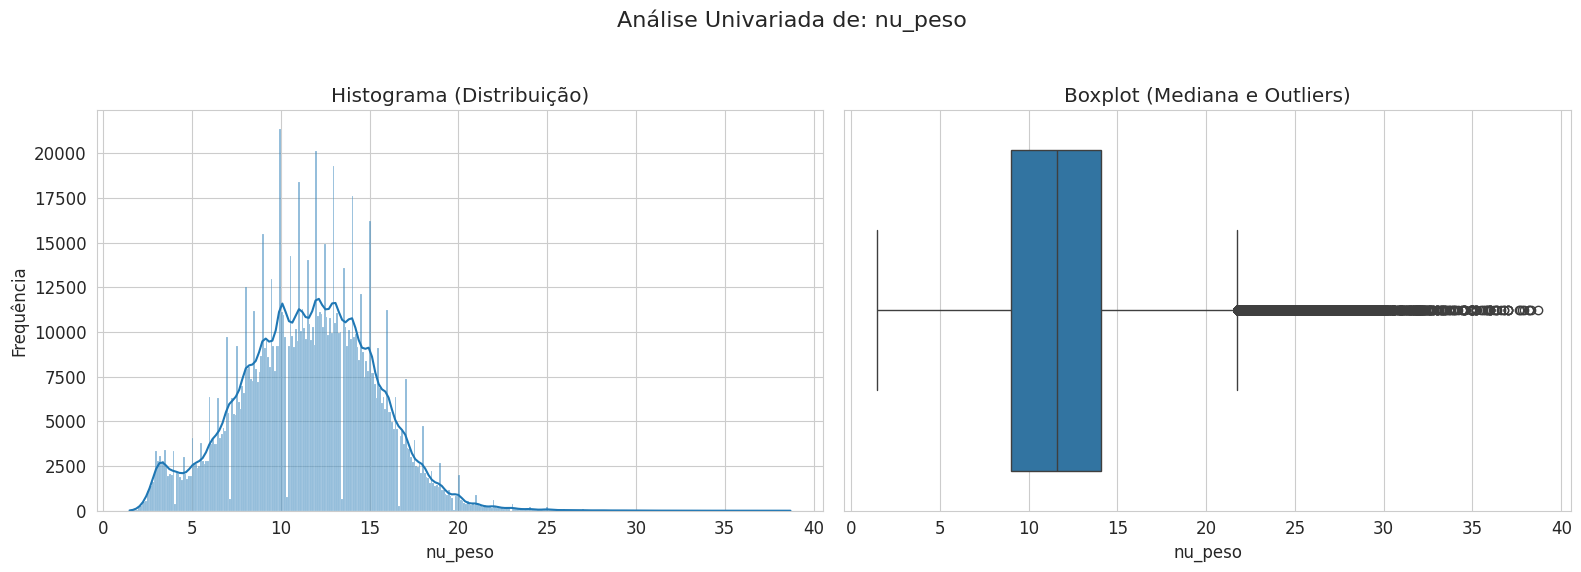

Analisando: nu_altura


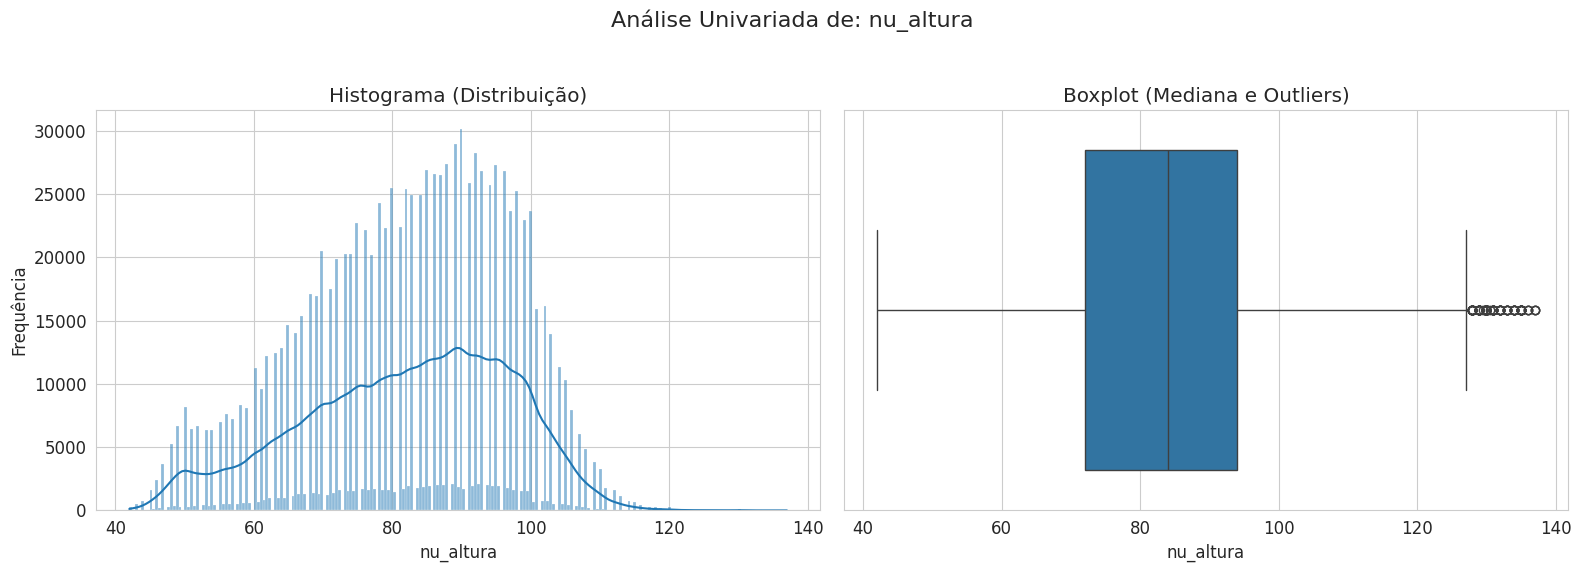

Analisando: idade_meses_atend


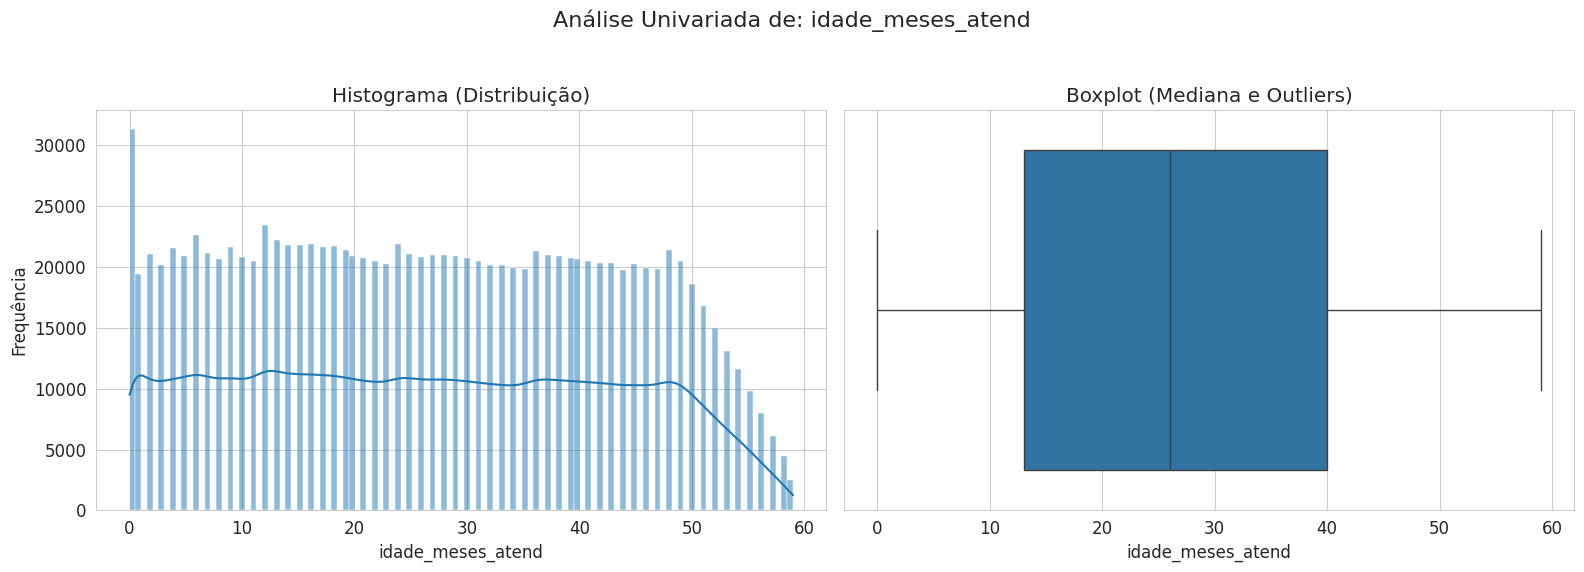

In [ ]:
print("Iniciando a Análise Univariada (Tarefa 2.2)...")
print("="*50 + "\n")

print("--- 1. Análise de Variáveis Numéricas ---")

# 1.1. Lista das nossas variáveis numéricas de interesse
numerical_vars = ['nu_peso', 'nu_altura', 'idade_meses_atend']

# 1.2. Estatísticas Descritivas
print("Estatísticas Descritivas (Numéricas):")
# .describe() nos dá a contagem (count), média (mean), desvio padrão (std),
# mínimo (min), quartis (25%, 50%, 75%) e máximo (max).
# Note que a 'count' só considera valores não-nulos.
estatisticas_num = df_criancas[numerical_vars].describe()
# display(estatisticas_num) # Use display() se estiver no Jupyter/Colab
print(estatisticas_num)
print("\n")

print("Gerando gráficos para variáveis numéricas...")

for var in numerical_vars:
    print(f"Analisando: {var}")

    # Precisamos remover os valores nulos (NaN) para plotar
    # O dropna() aqui só afeta 'data_to_plot', não o seu df_criancas original
    data_to_plot = df_criancas[var].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    fig.suptitle(f'Análise Univariada de: {var}', fontsize=16)

    # Gráfico 1: Histograma (para ver a distribuição)
    sns.histplot(data_to_plot, kde=True, ax=axes[0])
    axes[0].set_title('Histograma (Distribuição)')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Frequência')

    # Gráfico 2: Boxplot (para ver outliers)
    sns.boxplot(x=data_to_plot, ax=axes[1])
    axes[1].set_title('Boxplot (Mediana e Outliers)')
    axes[1].set_xlabel(var)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout para o título
    plt.show()

print("\n" + "="*50 + "\n")


### Análise da Variável: Peso (`nu_peso`)

A distribuição do peso (`nu_peso`) apresenta uma **forte assimetria à direita** (right-skew). O histograma revela uma grande concentração de registros com um pico de frequência em torno de 10-12 kg, com um pico menor para pesos muito baixos (provavelmente recém-nascidos). O boxplot confirma essa análise de forma contundente: enquanto a "caixa" (o intervalo interquartil, ou 50% central dos dados) está compactada em valores baixos (aprox. 8-14 kg), o gráfico é dominado por uma **longa cauda de outliers** à direita. A presença de milhares de registros acima de 20 kg (chegando até ~40 kg) "estica" o eixo do boxplot, comprimindo a visualização da maioria. Isso sugere fortemente a presença de um subgrupo significativo de crianças com sobrepeso/obesidade.

### Análise da Variável: Idade em Meses (`idade_meses_atend`)

Diferente do peso, a variável `idade_meses_atend` apresenta uma **distribuição quase uniforme**, o que é um excelente sinal para a análise. O histograma mostra que há um número relativamente consistente de atendimentos em todas as faixas etárias mensais, de 0 a 60 meses (5 anos). Há um pico notável de atendimentos em idades muito precoces (próximo de 0 meses), e um declínio natural após os 50 meses, indicando o limite de idade (5 anos) deste conjunto de dados. O boxplot reflete perfeitamente essa uniformidade: a "caixa" é larga e centrada, e os "bigodes" (whiskers) cobrem quase todo o intervalo, com **praticamente nenhuma presença de outliers**. Isso indica que os dados de idade são bem distribuídos e "limpos", sem valores atípicos que poderiam distorcer a análise.

### Análise da Variável: Altura (`nu_altura`)

A distribuição da altura (`nu_altura`) é particularmente interessante. O histograma sugere uma **distribuição bimodal** (com dois picos) ou, pelo menos, multimodal. Nota-se uma grande concentração de crianças em torno de 75-80 cm e outra em torno de 90-100 cm, com um "vale" (queda na frequência) entre elas. Isso é comum em dados que agregam diferentes faixas etárias; os picos podem simplesmente representar os grupos de crianças mais novas (ex: 1-2 anos) e mais velhas (ex: 3-4 anos). O boxplot mostra que a mediana (a linha central) está em torno de 85 cm, que é exatamente o "vale" entre os dois picos. Assim como no peso, vemos também uma cauda de outliers à direita (alturas acima de 120 cm), embora em menor quantidade, que podem ser erros de digitação (ex: 140 cm em vez de 104 cm) ou crianças mais velhas fora da curva.

Análise de Variáveis Categóricas
Gerando gráficos para variáveis categóricas...
Analisando: dsei_gestao


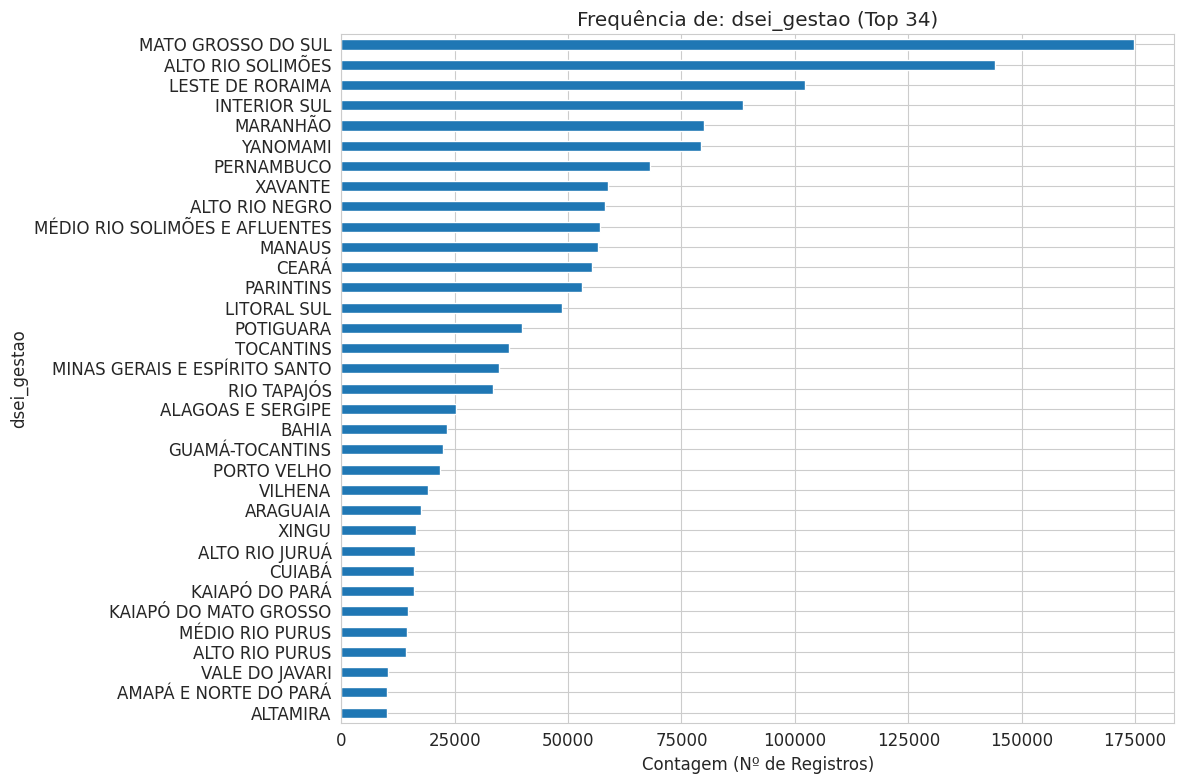

Contagens para 'dsei_gestao':
dsei_gestao
MATO GROSSO DO SUL                174840
ALTO RIO SOLIMÕES                 144083
LESTE DE RORAIMA                  102190
INTERIOR SUL                       88621
MARANHÃO                           79902
YANOMAMI                           79305
PERNAMBUCO                         68038
XAVANTE                            58843
ALTO RIO NEGRO                     58031
MÉDIO RIO SOLIMÕES E AFLUENTES     57033
MANAUS                             56572
CEARÁ                              55320
PARINTINS                          53121
LITORAL SUL                        48731
POTIGUARA                          39848
TOCANTINS                          36971
MINAS GERAIS E ESPÍRITO SANTO      34720
RIO TAPAJÓS                        33398
ALAGOAS E SERGIPE                  25391
BAHIA                              23342
GUAMÁ-TOCANTINS                    22360
PORTO VELHO                        21828
VILHENA                            19020
ARAGUAIA       

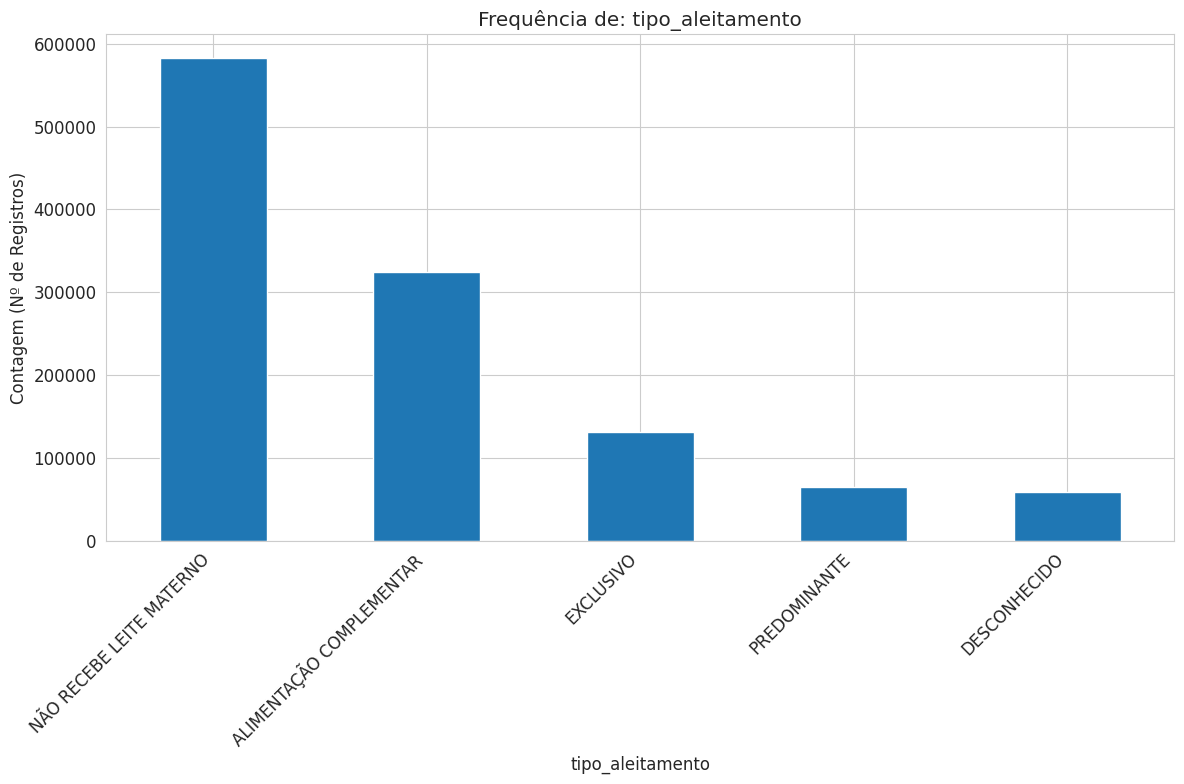

Contagens para 'tipo_aleitamento':
tipo_aleitamento
NÃO RECEBE LEITE MATERNO    582363
ALIMENTAÇÃO COMPLEMENTAR    324001
EXCLUSIVO                   131036
PREDOMINANTE                 65255
DESCONHECIDO                 58135
Name: count, dtype: int64


Análise Univariada concluída!


In [ ]:
print("Análise de Variáveis Categóricas")

categorical_vars = ['dsei_gestao', 'tipo_aleitamento']

print("Gerando gráficos para variáveis categóricas...")

for var in categorical_vars:
    print(f"Analisando: {var}")

    counts = df_criancas[var].value_counts()

    plt.figure(figsize=(12, 8))

    if len(counts) > 10:
        # Usamos .sort_values(ascending=True) para o maior ficar no topo
        counts.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Frequência de: {var} (Top {len(counts)})')
        plt.xlabel('Contagem (Nº de Registros)')
        plt.ylabel(var)
    else:
        counts.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Frequência de: {var}')
        plt.ylabel('Contagem (Nº de Registros)')
        plt.xlabel(var)
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print(f"Contagens para '{var}':")
    print(counts)
    print("\n")

print("="*50)
print("Análise Univariada concluída!")

## **RQ2: Distribuição Geográfica dos Indicadores**

In [ ]:
df_criancas['dsei_gestao'].unique()

array(['MÉDIO RIO SOLIMÕES E AFLUENTES', 'YANOMAMI', 'MATO GROSSO DO SUL',
       'LESTE DE RORAIMA', 'ALTO RIO JURUÁ', 'INTERIOR SUL',
       'ALTO RIO SOLIMÕES', 'CUIABÁ', 'XAVANTE', 'VILHENA',
       'ALAGOAS E SERGIPE', 'MÉDIO RIO PURUS', 'XINGU', 'PORTO VELHO',
       'MARANHÃO', 'PARINTINS', 'LITORAL SUL', 'KAIAPÓ DO PARÁ',
       'ALTO RIO NEGRO', 'MANAUS', 'POTIGUARA', 'ALTO RIO PURUS', 'BAHIA',
       'RIO TAPAJÓS', 'GUAMÁ-TOCANTINS', 'TOCANTINS', 'PERNAMBUCO',
       'AMAPÁ E NORTE DO PARÁ', 'MINAS GERAIS E ESPÍRITO SANTO',
       'VALE DO JAVARI', 'CEARÁ', 'ARAGUAIA', 'KAIAPÓ DO MATO GROSSO',
       'ALTAMIRA'], dtype=object)

In [ ]:
df_criancas['ds_peso_idade'].unique()

array(['PESO ADEQUADO PARA A IDADE', nan, 'PESO ELEVADO PARA A IDADE',
       'BAIXO PESO PARA A IDADE', 'MUITO BAIXO PESO PARA A IDADE',
       'NÃO SE APLICA'], dtype=object)

In [ ]:
df_criancas['ds_estatura_idade'].unique()

array(['ESTATURA ADEQUADA PARA A IDADE', nan,
       'MUITO BAIXA ESTATURA PARA A IDADE', 'BAIXA ESTATURA PARA A IDADE'],
      dtype=object)

Os valores do DSEI_gestão parecem não ser padronizados, apresentando diferentes formatos de representtações geográficas: alguns são municípios, outros regiões de rios e etc. Assim, para visualizar melhor a distribuição das categorias, podemos utilizar o município!

In [ ]:
df_criancas['co_municipio_ibge'].head()

,co_municipio_ibge
0,130280
1,130280
2,130280
3,130280
4,130280


### **Problemas nutricionais (peso para idade)**

In [ ]:
print("\n--- 1. Prevalência de Peso para Idade por Município (excluindo NaNs e 'NÃO SE APLICA') ---")

# Filtrar o DataFrame para remover NaNs e 'NÃO SE APLICA' da coluna 'ds_peso_idade'
df_peso_idade_filtrado = df_criancas[
    (df_criancas['ds_peso_idade'].notna()) &
    (df_criancas['ds_peso_idade'] != 'NÃO SE APLICA')
].copy() # Usar .copy() para evitar SettingWithCopyWarning

# Agrupar por município e contar os valores de ds_peso_idade
prevalencia_por_municipio = df_peso_idade_filtrado.groupby('no_municipio')['ds_peso_idade'].value_counts().unstack(fill_value=0)

# Calcular as porcentagens dentro de cada município
prevalencia_por_municipio_percentual = prevalencia_por_municipio.apply(lambda x: x / x.sum() * 100, axis=1)

print("\nContagem por Município e Diagnóstico de Peso para Idade:")
display(prevalencia_por_municipio.head()) # Exibir as primeiras linhas

print("\nPrevalência Percentual por Município e Diagnóstico de Peso para Idade:")
display(prevalencia_por_municipio_percentual.head()) # Exibir as primeiras linhas

# Opcional: Visualizar a distribuição em alguns municípios (exemplo com os 5 primeiros)
top_municipios = prevalencia_por_municipio.sum(axis=1).nlargest(5).index



--- 1. Prevalência de Peso para Idade por Município (excluindo NaNs e 'NÃO SE APLICA') ---

Contagem por Município e Diagnóstico de Peso para Idade:


ds_peso_idade,BAIXO PESO PARA A IDADE,MUITO BAIXO PESO PARA A IDADE,PESO ADEQUADO PARA A IDADE,PESO ELEVADO PARA A IDADE
no_municipio,,,,
ABARE,18,10,1281,86
ABATIA,0,0,165,35
ABELARDO LUZ,15,0,563,32
ACARAU,8,2,822,53
ACEGUA,0,0,8,0



Prevalência Percentual por Município e Diagnóstico de Peso para Idade:


ds_peso_idade,BAIXO PESO PARA A IDADE,MUITO BAIXO PESO PARA A IDADE,PESO ADEQUADO PARA A IDADE,PESO ELEVADO PARA A IDADE
no_municipio,,,,
ABARE,1.290323,0.716846,91.827957,6.164875
ABATIA,0.000000,0.000000,82.500000,17.500000
ABELARDO LUZ,2.459016,0.000000,92.295082,5.245902
ACARAU,0.903955,0.225989,92.881356,5.988701
ACEGUA,0.000000,0.000000,100.000000,0.000000


In [ ]:
print("--- 1. Preparando os dados de Nutrição ---")

# Filtrar o DataFrame
# Exclui NaNs e 'NÃO SE APLICA'
df_peso_idade_filtrado = df_criancas[
    (df_criancas['ds_peso_idade'].notna()) &
    (df_criancas['ds_peso_idade'] != 'NÃO SE APLICA')
].copy()

# Calcular as contagens por município
prevalencia_por_municipio = df_peso_idade_filtrado.groupby('no_municipio')['ds_peso_idade'].value_counts().unstack(fill_value=0)

# CATEGORIA MAIS FREQUENTE
# .idxmax(axis=1) retorna o nome da coluna (categoria) que tem o maior valor em cada linha (município)
df_frequente = prevalencia_por_municipio.idxmax(axis=1).to_frame(name='categoria_mais_frequente')

print("Categoria mais frequente por município:")
print(df_frequente.head())
print("\n")

# 1.4. Precisamos do 'co_municipio_ibge' para juntar com o mapa.
# criamosum "mapa" de 'no_municipio' para 'co_municipio_ibge'
# Usamos drop_duplicates para ter apenas uma linha por município
mapa_municipio_ibge = df_peso_idade_filtrado.drop_duplicates(subset=['no_municipio'])[['no_municipio', 'co_municipio_ibge']]


# Juntar a categoria mais frequente com o código IBGE
# 'df_frequente' é indexado por 'no_municipio'
dados_para_mapa = df_frequente.merge(
    mapa_municipio_ibge,
    left_index=True,       # Chave da esquerda (df_frequente) é o índice
    right_on='no_municipio' # Chave da direita é a coluna 'no_municipio'
)

print("Dados prontos para o merge com o mapa:")
# display(dados_para_mapa.head()) # Use display no Jupyter
print(dados_para_mapa.head())
print("\n")




--- 1. Preparando os dados de Nutrição ---
Categoria mais frequente por município:
                categoria_mais_frequente
no_municipio                            
ABARE         PESO ADEQUADO PARA A IDADE
ABATIA        PESO ADEQUADO PARA A IDADE
ABELARDO LUZ  PESO ADEQUADO PARA A IDADE
ACARAU        PESO ADEQUADO PARA A IDADE
ACEGUA        PESO ADEQUADO PARA A IDADE


Dados prontos para o merge com o mapa:
          categoria_mais_frequente  no_municipio  co_municipio_ibge
17107   PESO ADEQUADO PARA A IDADE         ABARE             290020
14120   PESO ADEQUADO PARA A IDADE        ABATIA             410010
24175   PESO ADEQUADO PARA A IDADE  ABELARDO LUZ             420010
9830    PESO ADEQUADO PARA A IDADE        ACARAU             230020
711810  PESO ADEQUADO PARA A IDADE        ACEGUA             430003




**Todos os municípios parecem ter como categoria mais frequente  PESO ADEQUADO PARA A IDADE**

In [ ]:
print("--- 2. Testando Variação da Categoria Mais Frequente ---")

# Verificação 1: Usar value_counts() para ver a distribuição
# Isso mostra exatamente quantas cidades caem em cada categoria principal.
print("Distribuição das categorias mais frequentes:")
contagem_categorias = dados_para_mapa['categoria_mais_frequente'].value_counts()

print(contagem_categorias)
print("\n")


# Teste lógico com nunique()
# .nunique() retorna apenas o NÚMERO de itens únicos.
num_categorias_unicas = dados_para_mapa['categoria_mais_frequente'].nunique()

print(f"Total de municípios analisados: {len(dados_para_mapa)}")
print(f"Número de categorias únicas encontradas: {num_categorias_unicas}")
print("\n")

# Resultado final do teste
if num_categorias_unicas == 1:
    categoria_unica = contagem_categorias.index[0]
    print(f"RESULTADO DO TESTE: SIM, todos os {len(dados_para_mapa)} municípios têm o MESMO valor.")
    print(f"A única categoria mais frequente é: '{categoria_unica}'")
elif num_categorias_unicas > 1:
    print(f"RESULTADO DO TESTE: NÃO, os municípios têm valores diferentes.")
    print(f"Foram encontrados {num_categorias_unicas} valores distintos (listados acima).")
    print("Portanto, o mapa coroplético mostrará variação de cores.")
else:
    # Isso só aconteceria se 'dados_para_mapa' estivesse vazio
    print("RESULTADO DO TESTE: Nenhum dado encontrado para testar.")

print("\n" + "="*50)

--- 2. Testando Variação da Categoria Mais Frequente ---
Distribuição das categorias mais frequentes:
categoria_mais_frequente
PESO ADEQUADO PARA A IDADE    490
Name: count, dtype: int64


Total de municípios analisados: 490
Número de categorias únicas encontradas: 1


RESULTADO DO TESTE: SIM, todos os 490 municípios têm o MESMO valor.
A única categoria mais frequente é: 'PESO ADEQUADO PARA A IDADE'




O teste que fizemos no passo anterior procura a categoria mais frequente (a moda) em cada município. O resultado de 'PESO ADEQUADO PARA A IDADE' ser o vencedor em todos os lugares significa simplesmente que, em todos os municípios, a maioria das crianças (ou pelo menos o maior grupo individual) se enquadra na faixa de normalidade.

Isso é um sinal positivo, mas torna o mapa (o de "categoria mais frequente") pouco útil, pois ele seria pintado com uma cor só.

Então, a pergunta analítica mais rica agora é: "Ok, se ignorarmos as crianças com peso adequado, qual é o problema nutricional mais comum em cada município?"

Estamos essencialmente "dando zoom" nos dados, filtrando a normalidade para focar nos desvios:

Desnutrição ('BAIXO PESO PARA A IDADE', 'MUITO BAIXO PESO PARA A IDADE')

Sobrepeso ('PESO ELEVADO PARA A IDADE')

Ao fazer isso, conseguiremos criar um mapa que mostra clusters geográficos: "Estes municípios têm a desnutrição como principal problema" vs. "Aqueles municípios têm o sobrepeso como principal problema".


--- 1. Revisitando Contagens e Definindo Categorias ---
Contagem apenas das categorias de 'Problema' (amostra):
ds_peso_idade  BAIXO PESO PARA A IDADE  MUITO BAIXO PESO PARA A IDADE  \
no_municipio                                                            
ABARE                               18                             10   
ABATIA                               0                              0   
ABELARDO LUZ                        15                              0   
ACARAU                               8                              2   
ACEGUA                               0                              0   

ds_peso_idade  PESO ELEVADO PARA A IDADE  
no_municipio                              
ABARE                                 86  
ABATIA                                35  
ABELARDO LUZ                          32  
ACARAU                                53  
ACEGUA                                 0  


Problema nutricional mais frequente por município (amostra):
            

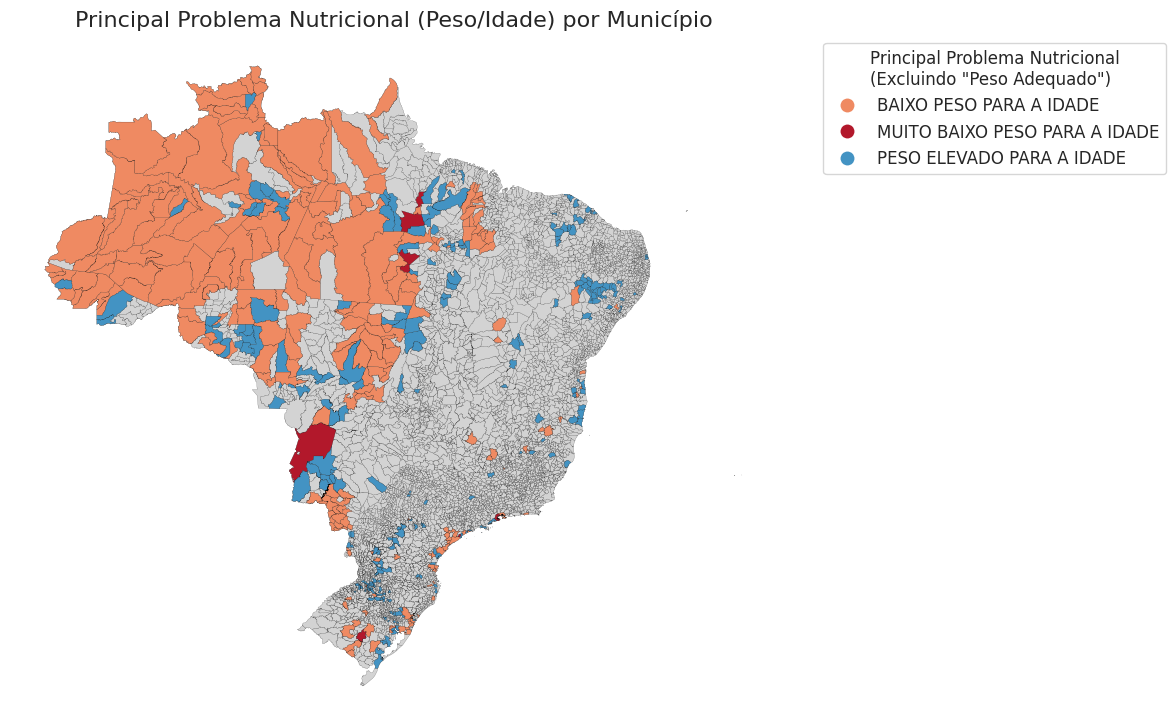

In [ ]:
print("--- 1. Revisitando Contagens e Definindo Categorias ---")

# Definir as colunas que representam "problemas"
categorias_problema = [
    'PESO ELEVADO PARA A IDADE',
    'BAIXO PESO PARA A IDADE',
    'MUITO BAIXO PESO PARA A IDADE'
]

# Filtrar o DataFrame de prevalência para conter APENAS as categorias de problema
# Usamos .reindex() para garantir que colunas que não existam em algum município
# sejam preenchidas com 0, evitando erros.
colunas_presentes = [col for col in prevalencia_por_municipio.columns if col in categorias_problema]
df_problemas = prevalencia_por_municipio[colunas_presentes]

print("Contagem apenas das categorias de 'Problema' (amostra):")

print(df_problemas.head())
print("\n")

# ACHAR O 'PROBLEMA' MAIS FREQUENTE
# Aplicamos o idxmax neste DataFrame filtrado
df_frequente_problema = df_problemas.idxmax(axis=1).to_frame(name='problema_mais_frequente')

print("Problema nutricional mais frequente por município (amostra):")

print(df_frequente_problema.head())
print("\n")

# Juntar o 'problema mais frequente' com o código IBGE
dados_para_mapa = df_frequente_problema.merge(
    mapa_municipio_ibge,
    left_index=True,
    right_on='no_municipio'
)

print("Dados finais prontos para o merge com o mapa:")
print(dados_para_mapa.head())
print("\n")


print("--- 2. Carregando Dados Geográficos (Shapefiles) ---")
try:
    gdf_municipios = geobr.read_municipality(year=2020)
    print("Shapefile dos municípios do Brasil carregado com sucesso.")

    # Ajuste da chave de 7 para 6 dígitos
    gdf_municipios['co_ibge_6dig'] = gdf_municipios['code_muni'].astype(str).str[:6].astype(int)
    print("Coluna 'co_ibge_6dig' criada para o merge.")
    print("\n")

    print("--- 3. Unindo seus Dados ao Mapa (Merge) ---")

    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(str)

    dados_para_mapa['co_municipio_ibge_numeric'] = pd.to_numeric(dados_para_mapa['co_municipio_ibge'], errors='coerce')


    nan_values_after_coerce = dados_para_mapa[dados_para_mapa['co_municipio_ibge_numeric'].isna()]
    if not nan_values_after_coerce.empty:
        print(f"Found {len(nan_values_after_coerce)} rows with non-numeric 'co_municipio_ibge' after coercing to NaN.")
        print("Original non-numeric values:")
        print(nan_values_after_coerce['co_municipio_ibge'].unique())

        dados_para_mapa.dropna(subset=['co_municipio_ibge_numeric'], inplace=True)
        print("Dropped rows with non-numeric 'co_municipio_ibge'.")

        dados_para_mapa.drop(columns=['co_municipio_ibge'], inplace=True)

        dados_para_mapa.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)

    else:
        print("No non-numeric values found in 'co_municipio_ibge' after coercing to NaN.")

        dados_para_mapa.drop(columns=['co_municipio_ibge'], inplace=True)
        dados_para_mapa.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)

    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(int)
    print(f"Dtype of 'co_municipio_ibge' in dados_para_mapa after converting to int: {dados_para_mapa['co_municipio_ibge'].dtype}")
    print(f"Dtype of 'co_ibge_6dig' in gdf_municipios: {gdf_municipios['co_ibge_6dig'].dtype}")


    mapa_final = gdf_municipios.merge(
        dados_para_mapa,
        left_on='co_ibge_6dig',
        right_on='co_municipio_ibge'
    )

    print(f"Merge concluído. Temos {len(mapa_final)} municípios com dados.")

    if mapa_final.empty:
        print("!! ERRO: O merge não encontrou municípios em comum. !!")
    else:
        print("\n--- 4. Plotando o Mapa Coroplético ---")

        # Definimos um mapa de cores para os PROBLEMAS
        color_map = {
            'MUITO BAIXO PESO PARA A IDADE': '#b2182b',
            'BAIXO PESO PARA A IDADE': '#ef8a62',
            'PESO ELEVADO PARA A IDADE': '#4393c3'
        }

        categorias_presentes_ordenadas = sorted(
            mapa_final['problema_mais_frequente'].dropna().unique()
        )

        print(f"Ordem das categorias que o Geopandas vai usar: {categorias_presentes_ordenadas}")

        # Criamos a LISTA de cores usando essa ordem alfabética
        lista_de_cores_ordenadas = [
            color_map[categoria] for categoria in categorias_presentes_ordenadas
        ]

        print(f"Lista de cores na ordem correta: {lista_de_cores_ordenadas}")

        # Terceiro, criamos o ListedColormap
        cmap = matplotlib.colors.ListedColormap(lista_de_cores_ordenadas)
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))


        gdf_municipios.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

        mapa_final.plot(
            column='problema_mais_frequente', # Coluna que define as cores
            categorical=True,                 # Essencial para categorias
            cmap=cmap,                        # Use the ListedColormap
            legend=True,
            legend_kwds={
                'title': 'Principal Problema Nutricional\n(Excluindo "Peso Adequado")',
                'bbox_to_anchor': (1.05, 1),
                'loc': 'upper left'
            },
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )


        ax.set_title('Principal Problema Nutricional (Peso/Idade) por Município', fontsize=16)
        ax.axis('off')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Ocorreu um erro durante o processo de geração do mapa: {e}")
    print("Verifique se as bibliotecas 'geopandas' e 'geobr' estão instaladas.")

A análise do indicador Peso/Idade revela a "dupla carga da má nutrição" que afeta os territórios indígenas. Por um lado, vemos uma concentração de municípios (em laranja e azul) onde o principal problema é a desnutrição aguda (Baixo Peso ou Muito Baixo Peso), especialmente nas regiões Norte e Centro-Oeste. Por outro lado, uma mancha azul significativa, também na Região Norte (notavelmente Pará e Amapá) e espalhada pelo Centro-Oeste e Sul, mostra o Peso Elevado como o problema mais frequente. Isso indica uma transição nutricional precária, onde a fome coexiste com o aumento do sobrepeso, provavelmente ligado ao acesso a alimentos ultraprocessados e de baixo valor nutritivo em detrimento da alimentação tradicional.

In [ ]:
print("--- 1. Preparando Dados (com Contagem) ---")

# 1.1. Definir as colunas que representam "problemas"
categorias_problema = [
    'PESO ELEVADO PARA A IDADE',
    'BAIXO PESO PARA A IDADE',
    'MUITO BAIXO PESO PARA A IDADE'
]

# 1.2. Filtrar o DataFrame de prevalência para conter APENAS as categorias de problema
colunas_presentes = [col for col in prevalencia_por_municipio.columns if col in categorias_problema]
df_problemas = prevalencia_por_municipio[colunas_presentes]

print("Contagem apenas das categorias de 'Problema' (amostra):")
print(df_problemas.head())
print("\n")

# --- 1.3: Capturar NOME e CONTAGEM ---
# 1.3.a. Achar o NOME do problema mais frequente
df_frequente_nome = df_problemas.idxmax(axis=1).to_frame(name='problema_mais_frequente')

# 1.3.b. Achar a CONTAGEM do problema mais frequente
# .max(axis=1) nos dá o número de crianças da categoria que venceu o idxmax
df_frequente_contagem = df_problemas.max(axis=1).to_frame(name='contagem_problema')

# 1.3.c. Juntar os dois
df_problema_info = df_frequente_nome.join(df_frequente_contagem)

print("Problema mais frequente E sua contagem (amostra):")

print(df_problema_info.head())
print("\n")


# --- 1.4: Usar df_problema_info ---
# 1.4. Juntar as informações do problema com o código IBGE
dados_para_mapa = df_problema_info.merge(
    mapa_municipio_ibge,
    left_index=True,
    right_on='no_municipio'
)

# Renomear coluna para ficar bonita no tooltip
dados_para_mapa.rename(columns={
    'contagem_problema': 'Nº de Crianças (Problema Principal)',
    'problema_mais_frequente': 'Problema Principal'
}, inplace=True)


print("Dados finais prontos para o merge com o mapa:")

print(dados_para_mapa.head())
print("\n")


print("--- 2. Carregando Dados Geográficos (Shapefiles) ---")
try:
    gdf_municipios = geobr.read_municipality(year=2020)
    print("Shapefile dos municípios do Brasil carregado com sucesso.")

    # 2.1. Ajuste da chave de 7 para 6 dígitos
    gdf_municipios['co_ibge_6dig'] = gdf_municipios['code_muni'].astype(str).str[:6].astype(int)
    print("Coluna 'co_ibge_6dig' criada para o merge.")
    print("\n")


    # --- PASSO 3: Limpeza de Chaves e Merge ---
    print("--- 3. Limpando Chaves e Unindo Dados ao Mapa ---")

    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(str)
    dados_para_mapa['co_municipio_ibge_numeric'] = pd.to_numeric(dados_para_mapa['co_municipio_ibge'], errors='coerce')

    nan_values_after_coerce = dados_para_mapa[dados_para_mapa['co_municipio_ibge_numeric'].isna()]
    if not nan_values_after_coerce.empty:
        print(f"Encontradas {len(nan_values_after_coerce)} linhas com 'co_municipio_ibge' não numérico. Removendo-as.")
        dados_para_mapa.dropna(subset=['co_municipio_ibge_numeric'], inplace=True)

    dados_para_mapa.drop(columns=['co_municipio_ibge'], inplace=True)
    dados_para_mapa.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)
    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(int)

    # Fazemos um 'left' merge para manter TODOS os municípios do Brasil
    # Os que não têm dados (à direita) ficarão com NaN
    mapa_final = gdf_municipios.merge(
        dados_para_mapa,
        left_on='co_ibge_6dig',
        right_on='co_municipio_ibge',
        how='left'
    )

    print(f"Merge 'left' concluído. O GeoDataFrame final tem {len(mapa_final)} municípios.")

    if mapa_final.empty:
        print("!! ERRO: O merge falhou. !!")
    else:
        print("\n--- 4. Plotando o Mapa Interativo com PLOTLY ---")

        # 4.1. Definir o mesmo mapa de cores
        color_map = {
            'MUITO BAIXO PESO PARA A IDADE': '#b2182b',
            'BAIXO PESO PARA A IDADE': '#ef8a62',
            'PESO ELEVADO PARA A IDADE': '#4393c3'
        }

        # 4.2. Criar a figura com Plotly Express
        fig = px.choropleth_mapbox(
            mapa_final,  # Nosso GeoDataFrame completo (com NaNs)
            geojson=mapa_final.geometry,  # Aponta para a coluna de geometria
            locations=mapa_final.index, # Identificador único de cada polígono

            color="Problema Principal",      # Coluna que define as cores
            color_discrete_map=color_map, # Nosso dicionário de cores

            # Informações que aparecem no Tooltip (ao passar o mouse)
            hover_name="name_muni", # Nome do município (vem do geobr)
            hover_data={
                "Problema Principal": True, # Mostra o problema
                "Nº de Crianças (Problema Principal)": True # Mostra a contagem
            },

            # Configurações do Mapa
            mapbox_style="carto-positron", # Estilo de mapa base (limpo)
            center={"lat": -14.2350, "lon": -51.9253}, # Centraliza no Brasil
            zoom=3.5,
            opacity=0.8 # Leve transparência para ver o mapa base
        )

        # 4.3. Ajustar o layout da legenda
        fig.update_layout(
            title_text='Principal Problema Nutricional (Peso/Idade) por Município',
            legend_title_text='Principal Problema Nutricional<br>(Excluindo "Peso Adequado")',
            margin={"r":0, "t":30, "l":0, "b":0} # Remove margens desnecessárias
        )

        # 4.4. Mostrar o gráfico interativo
        fig.show()

except Exception as e:
    print(f"Ocorreu um erro durante o processo de geração do mapa: {e}")
    print("Verifique se as bibliotecas 'geopandas', 'geobr' e 'plotly' estão instaladas.")

--- 1. Preparando Dados (com Contagem) ---
Contagem apenas das categorias de 'Problema' (amostra):
ds_peso_idade  BAIXO PESO PARA A IDADE  MUITO BAIXO PESO PARA A IDADE  \
no_municipio                                                            
ABARE                               18                             10   
ABATIA                               0                              0   
ABELARDO LUZ                        15                              0   
ACARAU                               8                              2   
ACEGUA                               0                              0   

ds_peso_idade  PESO ELEVADO PARA A IDADE  
no_municipio                              
ABARE                                 86  
ABATIA                                35  
ABELARDO LUZ                          32  
ACARAU                                53  
ACEGUA                                 0  


Problema mais frequente E sua contagem (amostra):
                problema_mais_freque

### Problemas de desenvolvimento (estatura para idade)

In [ ]:
print("\n--- 1. Prevalência de Estatura para Idade por Município (excluindo NaNs e 'NÃO SE APLICA') ---")

# Filtrar o DataFrame para remover NaNs e 'NÃO SE APLICA' da coluna 'ds_estatura_idade'
df_peso_idade_filtrado = df_criancas[
    (df_criancas['ds_estatura_idade'].notna())
].copy() # Usamos .copy() para evitar SettingWithCopyWarning

# Agrupar por município e contar os valores de ds_estatura_idade
prevalencia_por_municipio = df_peso_idade_filtrado.groupby('no_municipio')['ds_estatura_idade'].value_counts().unstack(fill_value=0)

# Calcular as porcentagens dentro de cada município
prevalencia_por_municipio_percentual = prevalencia_por_municipio.apply(lambda x: x / x.sum() * 100, axis=1)

print("\nContagem por Município e Diagnóstico de Estatura para Idade:")
display(prevalencia_por_municipio.head()) # Exibir as primeiras linhas

print("\nPrevalência Percentual por Município e Diagnóstico de Estatura para Idade:")
display(prevalencia_por_municipio_percentual.head()) # Exibir as primeiras linhas

top_municipios = prevalencia_por_municipio.sum(axis=1).nlargest(5).index


In [ ]:
print("--- 1. Preparando os dados de Estatura ---")

# Filtrar o DataFrame
# Exclui NaNs e 'NÃO SE APLICA'
df_estatura_idade_filtrado = df_criancas[
    (df_criancas['ds_estatura_idade'].notna())
].copy()

# Calcular as contagens por município
prevalencia_por_municipio = df_estatura_idade_filtrado.groupby('no_municipio')['ds_estatura_idade'].value_counts().unstack(fill_value=0)

# ACHAR A CATEGORIA MAIS FREQUENTE
# .idxmax(axis=1) retorna o nome da coluna (categoria) que tem o maior valor em cada linha (município)
df_frequente = prevalencia_por_municipio.idxmax(axis=1).to_frame(name='categoria_mais_frequente')

print("Categoria mais frequente por município:")

print(df_frequente.head())
print("\n")

# Precisamos do 'co_municipio_ibge' para juntar com o mapa.
# Vamos criar um "mapa" de 'no_municipio' para 'co_municipio_ibge'
# Usamos drop_duplicates para ter apenas uma linha por município
mapa_municipio_ibge = df_estatura_idade_filtrado.drop_duplicates(subset=['no_municipio'])[['no_municipio', 'co_municipio_ibge']]


# Juntar a categoria mais frequente com o código IBGE
# 'df_frequente' é indexado por 'no_municipio'
dados_para_mapa = df_frequente.merge(
    mapa_municipio_ibge,
    left_index=True,       # Chave da esquerda (df_frequente) é o índice
    right_on='no_municipio' # Chave da direita é a coluna 'no_municipio'
)

print("Dados prontos para o merge com o mapa:")
# display(dados_para_mapa.head())
print(dados_para_mapa.head())
print("\n")

**Todos os municípios parecem ter como categoria mais frequente ESTATURA ADEQUADA PARA A IDADE**

In [ ]:
print("--- 2. Testando Variação da Categoria Mais Frequente ---")

# Usamos value_counts() para ver a distribuição
# Isso mostra exatamente quantas cidades caem em cada categoria principal.
print("Distribuição das categorias mais frequentes:")
contagem_categorias = dados_para_mapa['categoria_mais_frequente'].value_counts()
print(contagem_categorias)
print("\n")

# Teste lógico com nunique()
# .nunique() retorna apenas o NÚMERO de itens únicos.
num_categorias_unicas = dados_para_mapa['categoria_mais_frequente'].nunique()

print(f"Total de municípios analisados: {len(dados_para_mapa)}")
print(f"Número de categorias únicas encontradas: {num_categorias_unicas}")
print("\n")

# Resultado final do teste
if num_categorias_unicas == 1:
    # .index[0] pega o nome da única categoria encontrada
    categoria_unica = contagem_categorias.index[0]
    print(f"RESULTADO DO TESTE: SIM, todos os {len(dados_para_mapa)} municípios têm o MESMO valor.")
    print(f"A única categoria mais frequente é: '{categoria_unica}'")
elif num_categorias_unicas > 1:
    print(f"RESULTADO DO TESTE: NÃO, os municípios têm valores diferentes.")
    print(f"Foram encontrados {num_categorias_unicas} valores distintos (listados acima).")
    print("Portanto, o mapa coroplético mostrará variação de cores.")
else:
    # Isso só aconteceria se 'dados_para_mapa' estivesse vazio
    print("RESULTADO DO TESTE: Nenhum dado encontrado para testar.")

print("\n" + "="*50)


O teste que fizemos no passo anterior procura a categoria mais frequente (a moda) em cada município. O resultado de 'ESTATURA ADEQUADA PARA A IDADE' ser o vencedor em 471 dos 490 municípios significa simplesmente que, na grande maioria os municípios, a maioria das crianças (ou pelo menos o maior grupo individual) se enquadra na faixa de normalidade.

Isso é um sinal positivo, mas torna o mapa (o de "categoria mais frequente") pouco útil, pois ele seria pintado quase completamente de uma cor só, o que poderia inclusive atrapalhar análises interessantes.




Primeiramente vou plotar os municípios com mais crianças fora da normalidade (desnutrição ou sobrepeso) do que dentro da normalidade, para identificar sua localização.


--- 1. Revisitando Contagens e Definindo Categorias ---
Contagem apenas das categorias de 'Problema' (amostra):
ds_estatura_idade  BAIXA ESTATURA PARA A IDADE  \
no_municipio                                     
ABARE                                       56   
ABATIA                                       1   
ABELARDO LUZ                                62   
ACARAU                                      31   
ACEGUA                                       3   

ds_estatura_idade  MUITO BAIXA ESTATURA PARA A IDADE  
no_municipio                                          
ABARE                                             25  
ABATIA                                             0  
ABELARDO LUZ                                      32  
ACARAU                                            22  
ACEGUA                                             1  


Problema de estatura mais frequente por município (amostra):
                  problema_mais_frequente
no_municipio                             
ABARE

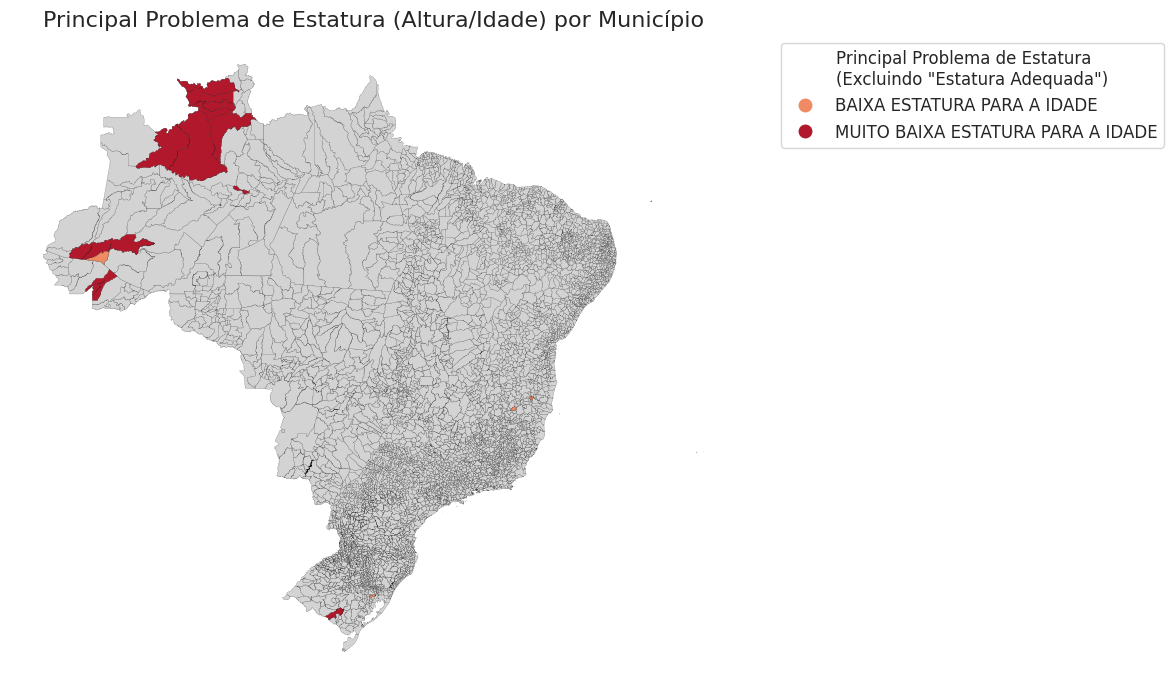

In [ ]:
print("--- 1. Revisitando Contagens e Definindo Categorias ---")

# Definir as colunas que representam "problemas" de baixa estatura
categorias_problema = [
    'MUITO BAIXA ESTATURA PARA A IDADE',
    'BAIXA ESTATURA PARA A IDADE'
]

# Filtrar o DataFrame de prevalência para conter APENAS as categorias de problema
# Usamos .reindex() para garantir que colunas que não existam em algum município
# sejam preenchidas com 0, evitando erros.
colunas_presentes = [col for col in prevalencia_por_municipio.columns if col in categorias_problema]
df_problemas = prevalencia_por_municipio[colunas_presentes]

print("Contagem apenas das categorias de 'Problema' (amostra):")
print(df_problemas.head())
print("\n")

# ACHAR O 'PROBLEMA' MAIS FREQUENTE ENTRE AS CATEGORIAS DE BAIXA ESTATURA
# Aplicamos o idxmax neste DataFrame FILTRADO
df_frequente_problema = df_problemas.idxmax(axis=1).to_frame(name='problema_mais_frequente')

print("Problema de estatura mais frequente por município (amostra):")
print(df_frequente_problema.head())
print("\n")

# Juntar o 'problema mais frequente' com o código IBGE
dados_para_mapa = df_frequente_problema.merge(
    mapa_municipio_ibge,
    left_index=True,
    right_on='no_municipio'
)

# Precisamos identificar quais municípios TINHAM 'ESTATURA ADEQUADA' como o mais frequente no DF original 'df_frequente'
municipios_com_estatura_adequada_mais_frequente = df_frequente[
    df_frequente['categoria_mais_frequente'] == 'ESTATURA ADEQUADA PARA A IDADE'
].index.tolist()

# Agora, filtramos o 'dados_para_mapa' para EXCLUIR esses municípios
dados_para_mapa_filtrado = dados_para_mapa[
    ~dados_para_mapa['no_municipio'].isin(municipios_com_estatura_adequada_mais_frequente)
].copy()

print("Dados finais prontos para o merge com o mapa (após filtrar 'Estatura Adequada'):")
print(dados_para_mapa_filtrado.head())
print(f"\nTotal de municípios após filtro: {len(dados_para_mapa_filtrado)}")
print("\n")


print("--- 2. Carregando Dados Geográficos (Shapefiles) ---")
try:
    gdf_municipios = geobr.read_municipality(year=2020)
    print("Shapefile dos municípios do Brasil carregado com sucesso.")

    # Ajuste da chave de 7 para 6 dígitos
    gdf_municipios['co_ibge_6dig'] = gdf_municipios['code_muni'].astype(str).str[:6].astype(int)
    print("Coluna 'co_ibge_6dig' criada para o merge.")
    print("\n")

    print("--- 3. Unindo seus Dados ao Mapa (Merge) ---")
    dados_para_mapa_filtrado['co_municipio_ibge'] = dados_para_mapa_filtrado['co_municipio_ibge'].astype(str)

    dados_para_mapa_filtrado['co_municipio_ibge_numeric'] = pd.to_numeric(dados_para_mapa_filtrado['co_municipio_ibge'], errors='coerce')


    nan_values_after_coerce = dados_para_mapa_filtrado[dados_para_mapa_filtrado['co_municipio_ibge_numeric'].isna()]
    if not nan_values_after_coerce.empty:
        print(f"Found {len(nan_values_after_coerce)} rows with non-numeric 'co_municipio_ibge' after coercing to NaN.")
        print("Original non-numeric values:")
        print(nan_values_after_coerce['co_municipio_ibge'].unique())

        dados_para_mapa_filtrado.dropna(subset=['co_municipio_ibge_numeric'], inplace=True)
        print("Dropped rows with non-numeric 'co_municipio_ibge'.")

        dados_para_mapa_filtrado.drop(columns=['co_municipio_ibge'], inplace=True)

        dados_para_mapa_filtrado.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)

    else:
        print("No non-numeric values found in 'co_municipio_ibge' after coercing to NaN.")

        dados_para_mapa_filtrado.drop(columns=['co_municipio_ibge'], inplace=True)
        dados_para_mapa_filtrado.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)



    dados_para_mapa_filtrado['co_municipio_ibge'] = dados_para_mapa_filtrado['co_municipio_ibge'].astype(int)
    print(f"Dtype of 'co_municipio_ibge' in dados_para_mapa_filtrado after converting to int: {dados_para_mapa_filtrado['co_municipio_ibge'].dtype}")
    print(f"Dtype of 'co_ibge_6dig' in gdf_municipios: {gdf_municipios['co_ibge_6dig'].dtype}")



    mapa_final = gdf_municipios.merge(
        dados_para_mapa_filtrado,
        left_on='co_ibge_6dig',
        right_on='co_municipio_ibge',
        how='left'
    )


    mapa_final_com_dados = mapa_final.dropna(subset=['problema_mais_frequente']).copy()

    print(f"Merge concluído. Temos {len(mapa_final_com_dados)} municípios com dados a serem plotados.")

    if mapa_final_com_dados.empty:
        print("!! NÃO HÁ MUNICÍPIOS PARA PLOTAR APÓS O FILTRO !!")
    else:
        print("\n--- 4. Plotando o Mapa Coroplético ---")

        color_map = {
            'MUITO BAIXA ESTATURA PARA A IDADE': '#b2182b',
            'BAIXA ESTATURA PARA A IDADE': '#ef8a62'
        }


        # Criamos o Colormap na ORDEM ALFABÉTICA correta
        # Primeiro, pegamos as categorias únicas que REALMENTE estão nos seus dados
        # e as ORDENAMOS alfabeticamente (com sorted())
        categorias_presentes_ordenadas = sorted(
            mapa_final_com_dados['problema_mais_frequente'].dropna().unique()
        )

        print(f"Ordem das categorias que o Geopandas vai usar: {categorias_presentes_ordenadas}")

        # criamos a LISTA de cores usando essa ordem alfabética
        lista_de_cores_ordenadas = [
            color_map[categoria] for categoria in categorias_presentes_ordenadas
        ]

        print(f"Lista de cores na ordem correta: {lista_de_cores_ordenadas}")

        #criamos o ListedColormap
        cmap = matplotlib.colors.ListedColormap(lista_de_cores_ordenadas)

        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        gdf_municipios.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)


        mapa_final_com_dados.plot(
            column='problema_mais_frequente',
            categorical=True,
            cmap=cmap,
            legend=True,
            legend_kwds={
                'title': 'Principal Problema de Estatura \n(Excluindo "Estatura Adequada")',
                'bbox_to_anchor': (1.05, 1),
                'loc': 'upper left'
            },
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )


        ax.set_title('Principal Problema de Estatura (Altura/Idade) por Município', fontsize=16)
        ax.axis('off')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Ocorreu um erro durante o processo de geração do mapa: {e}")
    print("Verifique se as bibliotecas 'geopandas' e 'geobr' estão instaladas.")

Os municípios com esse perfil parecem se concentrar muito na região Norte. Para além, a maioria deles apresenta como perfil majoritário MUITO BAIXA ESTATURA PARA IDADE, indicando que, quando a maioria das crianças não está na normalidade, a estatura delas não é apenas baixa, mas alarmantemente baixa.

Agora, a pergunta analítica mais rica é: "Ok, se ignorarmos as crianças com estatura adequada, qual é o problema nutricional mais comum em cada município?"

Estamos essencialmente "dando zoom" nos dados, filtrando a normalidade para focar nos desvios:

'BAIXA ESTATURA PARA A IDADE'
'MUITO BAIXA ESTATURA PARA A IDADE'

Ao fazer isso, conseguiremos criar um mapa que mostra clusters geográficos.

---



--- 1. Revisitando Contagens e Definindo Categorias ---
Contagem apenas das categorias de 'Problema' (amostra):
ds_estatura_idade  BAIXA ESTATURA PARA A IDADE  \
no_municipio                                     
ABARE                                       56   
ABATIA                                       1   
ABELARDO LUZ                                62   
ACARAU                                      31   
ACEGUA                                       3   

ds_estatura_idade  MUITO BAIXA ESTATURA PARA A IDADE  
no_municipio                                          
ABARE                                             25  
ABATIA                                             0  
ABELARDO LUZ                                      32  
ACARAU                                            22  
ACEGUA                                             1  


Problema de estatura mais frequente por município (amostra):
                  problema_mais_frequente
no_municipio                             
ABARE

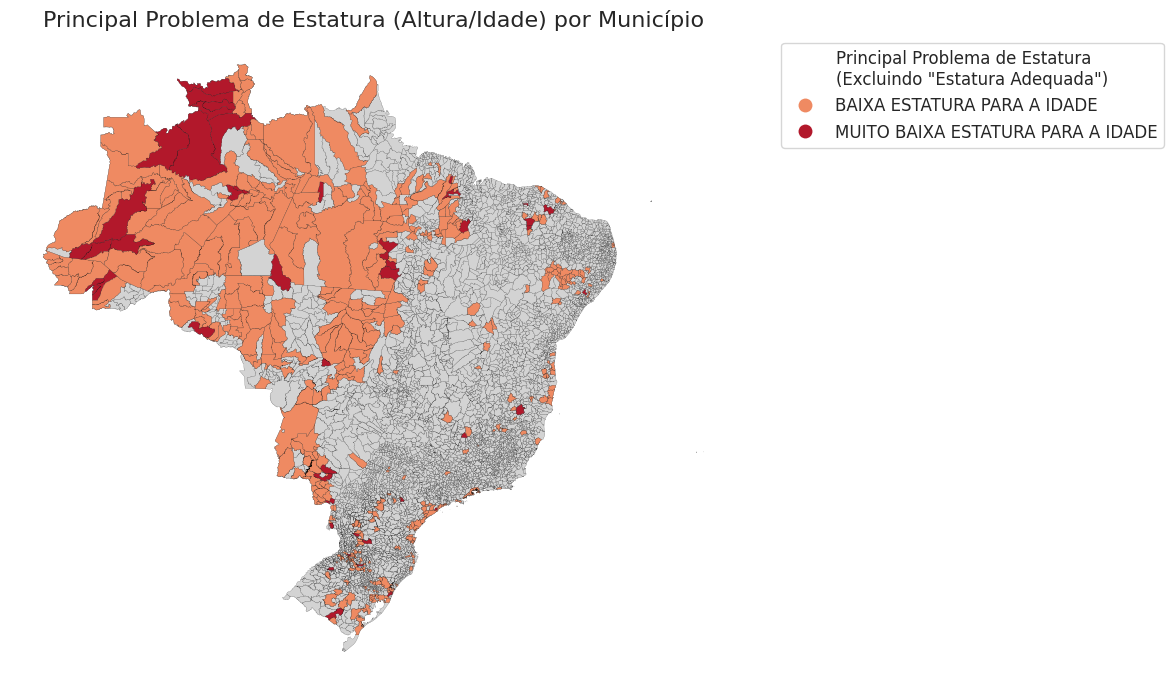

In [ ]:
print("--- 1. Revisitando Contagens e Definindo Categorias ---")

categorias_problema = [
    'MUITO BAIXA ESTATURA PARA A IDADE',
    'BAIXA ESTATURA PARA A IDADE'
]

# Filtramos o DataFrame de prevalência para conter APENAS as categorias de problema
# 'prevalencia_por_municipio' deve ter sido calculado antes (no script de Peso/Idade)
colunas_presentes = [col for col in prevalencia_por_municipio.columns if col in categorias_problema]
df_problemas = prevalencia_por_municipio[colunas_presentes]

print("Contagem apenas das categorias de 'Problema' (amostra):")
print(df_problemas.head())
print("\n")

# ACHAR O 'PROBLEMA' MAIS FREQUENTE
df_frequente_problema = df_problemas.idxmax(axis=1).to_frame(name='problema_mais_frequente')

print("Problema de estatura mais frequente por município (amostra):")
print(df_frequente_problema.head())
print("\n")

# Juntar o 'problema mais frequente' com o código IBGE
# 'mapa_municipio_ibge' deve ter sido calculado antes
dados_para_mapa = df_frequente_problema.merge(
    mapa_municipio_ibge,
    left_index=True,
    right_on='no_municipio'
)

print("Dados finais prontos para o merge com o mapa:")
print(dados_para_mapa.head())
print("\n")


print("--- 2. Carregando Dados Geográficos (Shapefiles) ---")
try:

    if 'gdf_municipios' not in locals():
        gdf_municipios = geobr.read_municipality(year=2020)
        print("Shapefile dos municípios do Brasil carregado com sucesso.")
        # Ajuste da chave de 7 para 6 dígitos
        gdf_municipios['co_ibge_6dig'] = gdf_municipios['code_muni'].astype(str).str[:6].astype(int)
        print("Coluna 'co_ibge_6dig' criada para o merge.")
    else:
        print("Shapefile 'gdf_municipios' já estava em memória.")
    print("\n")

    print("--- 3. Unindo seus Dados ao Mapa (Merge) ---")
    # Limpeza de chaves
    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(str)
    dados_para_mapa['co_municipio_ibge_numeric'] = pd.to_numeric(dados_para_mapa['co_municipio_ibge'], errors='coerce')
    nan_values_after_coerce = dados_para_mapa[dados_para_mapa['co_municipio_ibge_numeric'].isna()]
    if not nan_values_after_coerce.empty:
        print(f"Encontradas {len(nan_values_after_coerce)} linhas com 'co_municipio_ibge' não numérico. Removendo-as.")
        dados_para_mapa.dropna(subset=['co_municipio_ibge_numeric'], inplace=True)
    dados_para_mapa.drop(columns=['co_municipio_ibge'], inplace=True)
    dados_para_mapa.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)
    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(int)


    mapa_final = gdf_municipios.merge(
        dados_para_mapa,
        left_on='co_ibge_6dig',
        right_on='co_municipio_ibge'
    )

    print(f"Merge concluído. Temos {len(mapa_final)} municípios com dados.")

    if mapa_final.empty:
        print("!! ERRO: O merge não encontrou municípios em comum. !!")
    else:
        print("\n--- 4. Plotando o Mapa Coroplético ---")

        color_map = {
            'MUITO BAIXA ESTATURA PARA A IDADE': '#b2182b',
            'BAIXA ESTATURA PARA A IDADE': '#ef8a62'
        }


        # Criar o Colormap na ORDEM ALFABÉTICA correta
        # Ordenamos as categorias alfabeticamente
        categorias_presentes_ordenadas = sorted(
            mapa_final['problema_mais_frequente'].dropna().unique()
        )
        print(f"Ordem das categorias que o Geopandas vai usar: {categorias_presentes_ordenadas}")

        # Criamos a LISTA de cores usando essa ordem
        lista_de_cores_ordenadas = [
            color_map[categoria] for categoria in categorias_presentes_ordenadas
        ]
        print(f"Lista de cores na ordem correta: {lista_de_cores_ordenadas}")

        # Criamos o ListedColormap
        cmap = matplotlib.colors.ListedColormap(lista_de_cores_ordenadas)

        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        gdf_municipios.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

        mapa_final.plot(
            column='problema_mais_frequente',
            categorical=True,
            cmap=cmap,
            legend=True,
            legend_kwds={
                'title': 'Principal Problema de Estatura \n(Excluindo "Estatura Adequada")',
                'bbox_to_anchor': (1.05, 1),
                'loc': 'upper left'
            },
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )


        ax.set_title('Principal Problema de Estatura (Altura/Idade) por Município', fontsize=16)
        ax.axis('off')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Ocorreu um erro durante o processo de geração do mapa: {e}")
    print("Verifique se as bibliotecas 'geopandas' e 'geobr' estão instaladas.")

In [ ]:
print("--- 0. Calculando Prevalência de ESTATURA ---")

# Filtrar o DataFrame original para ESTATURA
df_estatura_filtrado = df_criancas[
    (df_criancas['ds_estatura_idade'].notna()) &
    (df_criancas['ds_estatura_idade'] != 'NÃO SE APLICA')
].copy()

# CALCULAR a prevalência por município PARA ESTATURA
# Isto irá SOBRESCREVER a variável antiga (de peso) com os dados corretos (de estatura)
prevalencia_por_municipio = df_estatura_filtrado.groupby('no_municipio')['ds_estatura_idade'].value_counts().unstack(fill_value=0)

# Recalcular o mapa_municipio_ibge também, para garantir
mapa_municipio_ibge = df_estatura_filtrado.drop_duplicates(subset=['no_municipio'])[['no_municipio', 'co_municipio_ibge']]

print("Prevalência de ESTATURA por Município (amostra):")
print(prevalencia_por_municipio.head())
print("\n" + "="*50 + "\n")

print("--- 1. Preparando Dados de Estatura (com Contagem) ---")

# Definir as colunas que representam "problemas" de ESTATURA
categorias_problema = [
    'MUITO BAIXA ESTATURA PARA A IDADE',
    'BAIXA ESTATURA PARA A IDADE'
]

# Filtrar o DataFrame de prevalência (agora de Estatura)
colunas_presentes = [col for col in prevalencia_por_municipio.columns if col in categorias_problema]
df_problemas = prevalencia_por_municipio[colunas_presentes]

print("Contagem apenas das categorias de 'Problema' (amostra):")
print(df_problemas.head())
print("\n")

# Capturar NOME e CONTAGEM
df_frequente_nome = df_problemas.idxmax(axis=1).to_frame(name='problema_mais_frequente')
df_frequente_contagem = df_problemas.max(axis=1).to_frame(name='contagem_problema')
df_problema_info = df_frequente_nome.join(df_frequente_contagem)

print("Problema mais frequente E sua contagem (amostra):")
print(df_problema_info.head())
print("\n")


# Usar df_problema_info
dados_para_mapa = df_problema_info.merge(
    mapa_municipio_ibge,
    left_index=True,
    right_on='no_municipio'
)

# Renomear colunas para o tooltip
dados_para_mapa.rename(columns={
    'contagem_problema': 'Nº de Crianças (Problema Principal)',
    'problema_mais_frequente': 'Problema Principal'
}, inplace=True)


print("Dados finais prontos para o merge com o mapa:")
print(dados_para_mapa.head())
print("\n")


print("--- 2. Carregando Dados Geográficos (Shapefiles) ---")
try:
    # Otimização: Só baixar se não existir na memória
    if 'gdf_municipios' not in locals():
        gdf_municipios = geobr.read_municipality(year=2020)
        print("Shapefile dos municípios do Brasil carregado com sucesso.")
        # 2.1. Ajuste da chave de 7 para 6 dígitos
        gdf_municipios['co_ibge_6dig'] = gdf_municipios['code_muni'].astype(str).str[:6].astype(int)
        print("Coluna 'co_ibge_6dig' criada para o merge.")
    else:
        print("Shapefile 'gdf_municipios' já estava em memória.")
    print("\n")


    # Limpeza de Chaves e Merge
    print("--- 3. Limpando Chaves e Unindo Dados ao Mapa ---")

    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(str)
    dados_para_mapa['co_municipio_ibge_numeric'] = pd.to_numeric(dados_para_mapa['co_municipio_ibge'], errors='coerce')

    nan_values_after_coerce = dados_para_mapa[dados_para_mapa['co_municipio_ibge_numeric'].isna()]
    if not nan_values_after_coerce.empty:
        print(f"Encontradas {len(nan_values_after_coerce)} linhas com 'co_municipio_ibge' não numérico. Removendo-as.")
        dados_para_mapa.dropna(subset=['co_municipio_ibge_numeric'], inplace=True)

    dados_para_mapa.drop(columns=['co_municipio_ibge'], inplace=True)
    dados_para_mapa.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)
    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(int)

    # Merge 'left' para manter o mapa do Brasil inteiro
    mapa_final = gdf_municipios.merge(
        dados_para_mapa,
        left_on='co_ibge_6dig',
        right_on='co_municipio_ibge',
        how='left'
    )

    print(f"Merge 'left' concluído. O GeoDataFrame final tem {len(mapa_final)} municípios.")

    if mapa_final.empty:
        print("!! ERRO: O merge falhou. !!")
    else:
        print("\n--- 4. Plotando o Mapa Interativo de ESTATURA com PLOTLY ---")

        color_map = {
            'MUITO BAIXA ESTATURA PARA A IDADE': '#b2182b',
            'BAIXA ESTATURA PARA A IDADE': '#ef8a62'
        }

        fig = px.choropleth_mapbox(
            mapa_final,
            geojson=mapa_final.geometry,
            locations=mapa_final.index,

            color="Problema Principal",
            color_discrete_map=color_map,

            hover_name="name_muni",
            hover_data={
                "Problema Principal": True,
                "Nº de Crianças (Problema Principal)": True
            },

            mapbox_style="carto-positron",
            center={"lat": -14.2350, "lon": -51.9253},
            zoom=3.5,
            opacity=0.8
        )

        # Ajustar o layout da legenda e título
        fig.update_layout(
            title_text='Principal Problema de Estatura (Altura/Idade) por Município', # <-- MUDANÇA
            legend_title_text='Principal Problema de Estatura<br>(Excluindo "Estatura Adequada")', # <-- MUDANÇA
            margin={"r":0, "t":30, "l":0, "b":0}
        )

        fig.show()

except Exception as e:
    print(f"Ocorreu um erro durante o processo de geração do mapa: {e}")
    print("Verifique se as bibliotecas 'geopandas', 'geobr' e 'plotly' estão instaladas.")

# **Parte 3**

## **Análise Bivariada - Teste de Hipóteses 1**

In [ ]:
print("--- Teste T: Diferença de Alturas (H0: Média F - Média M = 0) ---\n")

print("H0: Média(F) - Média(M) = 0")
print("HA: Média(F) - Média(M) ≠ 0\n")

altura_masc = df_criancas.loc[df_criancas['tp_sexo'] == 'M', 'nu_altura'].dropna()
altura_fem  = df_criancas.loc[df_criancas['tp_sexo'] == 'F', 'nu_altura'].dropna()

# Análise Descritiva
print(f"Registros válidos (M): {len(altura_masc)}")
print(f"Registros válidos (F): {len(altura_fem)}")
print(f"Média Masculino (M): {altura_masc.mean():.2f} cm")
print(f"Média Feminino (F):  {altura_fem.mean():.2f} cm\n")

#Teste T
t_stat, p_val = stats.ttest_ind(
    altura_fem,
    altura_masc,
    equal_var=False,
    nan_policy='omit'
)

print("--- Resultado do Teste T ---")
print(f"Estatística T: {t_stat:.4f}")
print(f"P-Valor: {p_val:.6f}\n")

#Graus de liberdade aproximados (fórmula de Welch-Satterthwaite)
s1, s2 = np.var(altura_fem, ddof=1), np.var(altura_masc, ddof=1)
n1, n2 = len(altura_fem), len(altura_masc)
df_welch = (s1/n1 + s2/n2)**2 / ((s1**2)/((n1**2)*(n1-1)) + (s2**2)/((n2**2)*(n2-1)))

#Intervalo de Confiança (95%)
media_dif = altura_fem.mean() - altura_masc.mean()
erro_padrao = np.sqrt(s1/n1 + s2/n2)
t_critico = stats.t.ppf(1 - 0.05/2, df_welch)
ic_inf = media_dif - t_critico * erro_padrao
ic_sup = media_dif + t_critico * erro_padrao

print("--- Intervalo de Confiança (95%) ---")
print(f"Graus de liberdade (Welch): {df_welch:.2f}")
print(f"Erro Padrão da Diferença: {erro_padrao:.4f}")
print(f"IC 95% para (Média F - Média M): ({ic_inf:.4f}, {ic_sup:.4f}) cm\n")

if abs(t_stat) > t_critico:
    print("Decisão: Rejeitamos H0.")
    print("Conclusão: Existe diferença estatisticamente significativa entre as alturas médias de meninos e meninas.")
else:
    print("Decisão: Falhamos em rejeitar H0.")
    print("Conclusão: Não há evidências de diferença significativa entre as alturas médias de meninos e meninas.")


--- Teste T: Diferença de Alturas (H0: Média F - Média M = 0) ---

H0: Média(F) - Média(M) = 0
HA: Média(F) - Média(M) ≠ 0

Registros válidos (M): 593179
Registros válidos (F): 567611
Média Masculino (M): 82.55 cm
Média Feminino (F):  81.52 cm

--- Resultado do Teste T ---
Estatística T: -37.2093
P-Valor: 0.000000

--- Intervalo de Confiança (95%) ---
Graus de liberdade (Welch): 1157767.07
Erro Padrão da Diferença: 0.0276
IC 95% para (Média F - Média M): (-1.0809, -0.9728) cm

Decisão: Rejeitamos H0.
Conclusão: Existe diferença estatisticamente significativa entre as alturas médias de meninos e meninas.


Plotando Histogramas de Altura por Sexo
Média (M) para o gráfico: 82.55 cm
Média (F) para o gráfico: 81.52 cm

Gráfico 'altura_sexo_histograma.png' salvo.


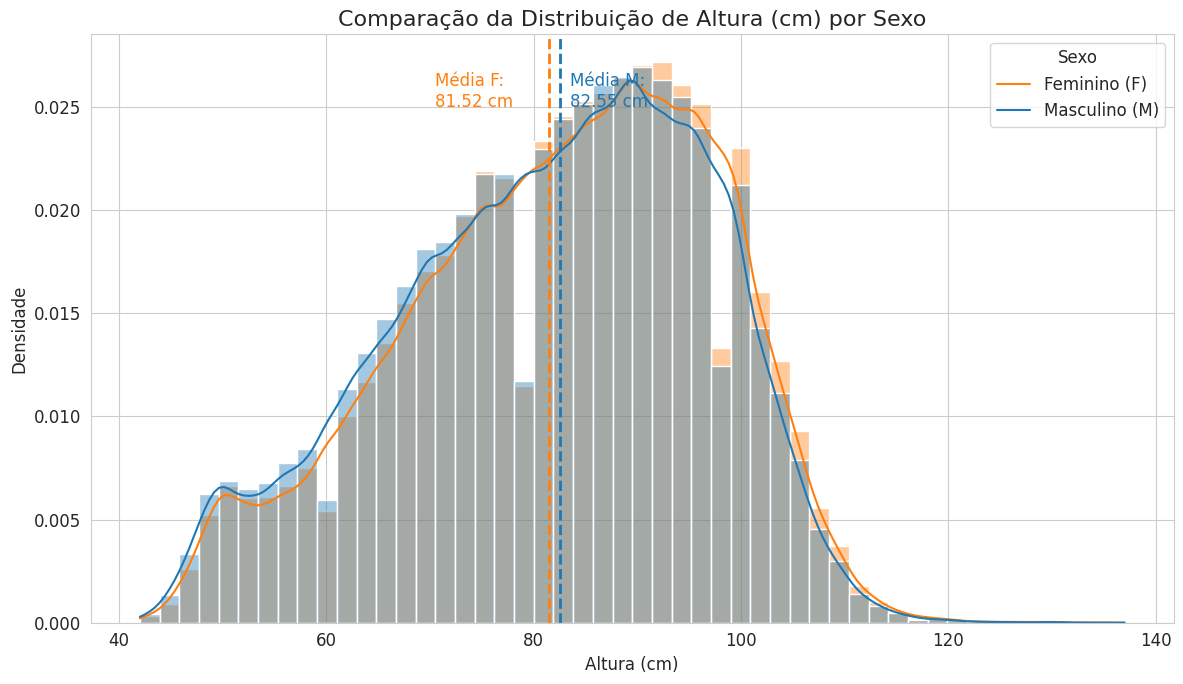

In [ ]:
print("Plotando Histogramas de Altura por Sexo")

sexos_validos = ['M', 'F']

# Filtrar o DataFrame principal
df_plot = df_criancas[
    (df_criancas['tp_sexo'].isin(sexos_validos)) &
    (df_criancas['nu_altura'].notna())
].copy()

# Calcular as Médias
# (O Teste T já fez isso, mas vamos recalcular para ter certeza)
media_m = df_plot.loc[df_plot['tp_sexo'] == 'M', 'nu_altura'].mean()
media_f = df_plot.loc[df_plot['tp_sexo'] == 'F', 'nu_altura'].mean()

print(f"Média (M) para o gráfico: {media_m:.2f} cm")
print(f"Média (F) para o gráfico: {media_f:.2f} cm")

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


sns.histplot(
    data=df_plot,
    x='nu_altura',
    hue='tp_sexo',
    stat="density",
    kde=True,
    common_norm=False,
    bins=50,
    alpha=0.4
)

plt.axvline(media_m, color=sns.color_palette()[0], linestyle='--', linewidth=2)
plt.axvline(media_f, color=sns.color_palette()[1], linestyle='--', linewidth=2)

plt.text(media_m + 1, 0.025, f'Média M:\n{media_m:.2f} cm', color=sns.color_palette()[0])
plt.text(media_f - 11, 0.025, f'Média F:\n{media_f:.2f} cm', color=sns.color_palette()[1])

plt.title('Comparação da Distribuição de Altura (cm) por Sexo', fontsize=16)
plt.xlabel('Altura (cm)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)

plt.legend(title='Sexo', labels=['Feminino (F)', 'Masculino (M)'])

plt.tight_layout()
plt.savefig("altura_sexo_histograma.png")
print("\nGráfico 'altura_sexo_histograma.png' salvo.")

## **RQ3: Aleitamento e Estado Nutricional - Teste de Hipóteses 2**

In [ ]:
print("--- Executando Teste Qui-Quadrado ---")

df_chi2 = df_criancas[
    (df_criancas['tipo_aleitamento'] != 'DESCONHECIDO') &
    (df_criancas['tipo_aleitamento'].notna()) &
    (df_criancas['ds_peso_idade'] != 'NÃO SE APLICA') &
    (df_criancas['ds_peso_idade'].notna())
]
tabela_contingencia = pd.crosstab(
    df_chi2['tipo_aleitamento'],
    df_chi2['ds_peso_idade']
)

#Execução do Teste
chi2_stat, p_value, dof, expected_freqs = chi2_contingency(tabela_contingencia)

print("Resultado do Teste Qui-Quadrado")
print(f"Estatística Qui-Quadrado: {chi2_stat:.4f}")
print(f"Graus de Liberdade (dof): {dof}")

#Interpretação do P-valor
print("Análise do P-Valor")
print(f"Valor 'cru' da variável p_value: {p_value}")

# Pega o menor número positivo que o Python pode representar
menor_numero_float = sys.float_info.min

if p_value == 0.0:
    print(f"Como reportar: 'p < {menor_numero_float:g}' (ou simplesmente 'p < .001')")
else:
    print(f"P-Valor (precisão total): {p_value:e}")

print("Conclusão Final")
alpha = 0.05
if p_value < alpha:
    print(f"Resultado (p < {alpha}): Rejeitamos a Hipótese Nula (H0).")
    print("Conclusão: Existe uma associação estatisticamente significativa entre o tipo de aleitamento e o estado nutricional (peso/idade).")
else:
    print(f"Resultado (p >= {alpha}): Falhamos em Rejeitar a Hipótese Nula (H0).")
    print("Conclusão: Não há evidência estatística suficiente para afirmar que existe uma associação entre as variáveis.")

--- Executando Teste Qui-Quadrado ---
Resultado do Teste Qui-Quadrado
Estatística Qui-Quadrado: 5338.1226
Graus de Liberdade (dof): 9
Análise do P-Valor
Valor 'cru' da variável p_value: 0.0
Como reportar: 'p < 2.22507e-308' (ou simplesmente 'p < .001')
Conclusão Final
Resultado (p < 0.05): Rejeitamos a Hipótese Nula (H0).
Conclusão: Existe uma associação estatisticamente significativa entre o tipo de aleitamento e o estado nutricional (peso/idade).


In [ ]:
alpha = 0.05 # nível de significância (95% de confiança)

valor_critico = stats.chi2.ppf(1 - alpha, df=dof)

print("--- Teste de Hipótese pelo Valor Crítico ---")
print(f"Nível de Significância (alpha): {alpha}")
print(f"Graus de Liberdade (dof): {dof}")
print("\n")
print(f"   Estatística Qui-Quadrado : {chi2_stat:.4f}")
print(f"   Valor Crítico (A 'Linha de Corte'): {valor_critico:.4f}")
print("\n")

# --- 3. A Regra da Decisão ---
if chi2_stat > valor_critico:
    print("Resultado: Nossa pontuação é MAIOR que a linha de corte.")
    print("Decisão: Rejeitamos a Hipótese Nula (H0).")
    print("\nConclusão: Existe uma associação estatisticamente significativa.")
else:
    print("Resultado: Nossa pontuação é MENOR ou IGUAL à linha de corte.")
    print("Decisão: Falhamos em Rejeitar a Hipótese Nula (H0).")
    print("\nConclusão: Não há evidência de associação.")

--- Teste de Hipótese pelo Valor Crítico ---
Nível de Significância (alpha): 0.05
Graus de Liberdade (dof): 9


   Estatística Qui-Quadrado : 5338.1226
   Valor Crítico (A 'Linha de Corte'): 16.9190


Resultado: Nossa pontuação é MAIOR que a linha de corte.
Decisão: Rejeitamos a Hipótese Nula (H0).

Conclusão: Existe uma associação estatisticamente significativa.


<>:42: SyntaxWarning:

invalid escape sequence '\l'

<>:42: SyntaxWarning:

invalid escape sequence '\l'

/tmp/ipython-input-1903798109.py:42: SyntaxWarning:

invalid escape sequence '\l'



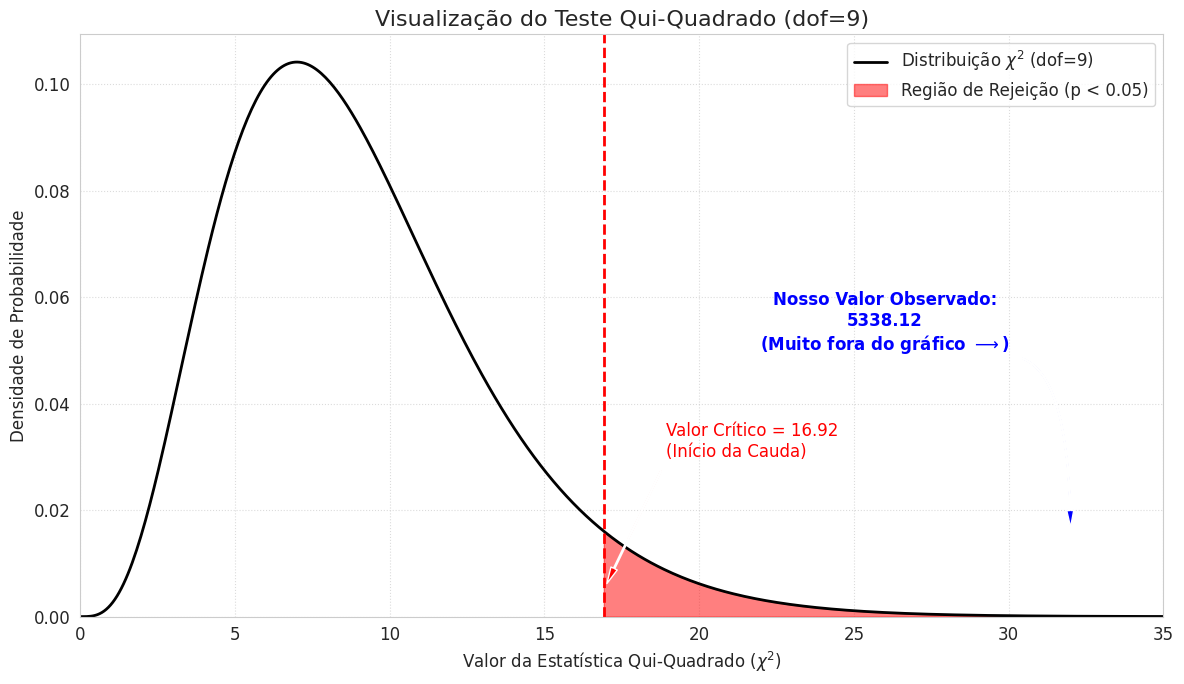

In [ ]:
# Nossos Parâmetros
dof = 9
chi2_stat_obs = 5338.1226
valor_critico = 16.9190
alpha = 0.05

#Preparar o Eixo X para o Gráfico
x_max_plot = 35
x = np.linspace(0, x_max_plot, 500)
pdf = stats.chi2.pdf(x, df=dof)

plt.figure(figsize=(12, 7))

# Adicionado 'r' antes do f' (rf')
plt.plot(x, pdf, label=rf'Distribuição $\chi^2$ (dof={dof})', color='black', linewidth=2)

# Sombrear a Cauda (Região de Rejeição)
x_tail = np.linspace(valor_critico, x_max_plot, 100)
pdf_tail = stats.chi2.pdf(x_tail, df=dof)

plt.fill_between(
    x_tail,
    pdf_tail,
    color='red',
    alpha=0.5,
    label=f'Região de Rejeição (p < {alpha})'
)

# Desenhar as Linhas e Anotações
plt.axvline(valor_critico, color='red', linestyle='--', linewidth=2)
plt.annotate(
    f'Valor Crítico = {valor_critico:.2f}\n(Início da Cauda)',
    xy=(valor_critico, 0.005),
    xytext=(valor_critico + 2, 0.03),
    arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5),
    ha='left',
    color='red'
)

# Adicionado 'r' antes do f' (rf')
plt.annotate(
    rf'Nosso Valor Observado:' + f'\n{chi2_stat_obs:.2f}\n(Muito fora do gráfico $\longrightarrow$)', # Quebrei a string para o rf' funcionar
    xy=(32, 0.015),
    xytext=(26, 0.05),
    arrowprops=dict(facecolor='blue', shrink=0.05, width=1, headwidth=5, connectionstyle="angle3,angleA=0,angleB=-90"),
    fontsize=12,
    ha='center',
    color='blue',
    fontweight='bold'
)

plt.title('Visualização do Teste Qui-Quadrado (dof=9)', fontsize=16)

# Adicionado 'r' antes do '...' (r')
plt.xlabel(r'Valor da Estatística Qui-Quadrado ($\chi^2$)', fontsize=12)
plt.ylabel('Densidade de Probabilidade', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.7)

plt.xlim(0, x_max_plot)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

## **RQ4: Impacto Combinado no Crescimento - Regressão Linear**

A importância desta Regressão Linear Múltipla reside na sua capacidade de ir além das análises descritivas, permitindo-nos **quantificar o impacto combinado e isolado** de múltiplos fatores sobre o crescimento infantil. Usando a altura (`nu_altura`) como variável-alvo, estamos a modelar o principal indicador da **desnutrição crônica** (nanismo), um problema de saúde pública fundamental.

In [ ]:
df_criancas.columns

Index(['co_indio_desidentificado', 'co_seq_acomp_nutricional',
       'dt_atendimento', 'idade_meses_atend', 'nu_peso', 'nu_altura',
       'idade_atend', 'ds_tipo_acomp_nutricional', 'tipo_aleitamento',
       'ds_peso_idade', 'ds_estatura_idade', 'ds_imc_idade', 'co_profissional',
       'co_ocupacao', 'ano_outlier_vigilancia', 'mes_atend_outlier_vigilancia',
       'ano_atend_outlier_vigilancia', 'idade_meses_atend_outlier',
       'idade_atend_outlier', 'co_terra_indigena', 'co_seq_morbidade',
       'co_localidade', 'co_cid10', 'no_categoria_subcategoria',
       'co_categoria_pai', 'idade_atend_em_dias', 'faixa_etaria_atend',
       'co_cbo_ocupacao', 'ano_outlier_acompanhamento',
       'mes_atend_outlier_acompanhamento', 'ano_atend_outlier_acompanhamento',
       'idade_atend_em_dias_outlier', 'dt_nascimento', 'idade_anos', 'ano',
       'dsei_gestao', 'co_dsei_gestao', 'cod_polo_base', 'ds_polo_base',
       'no_terra_indigena', 'co_municipio_ibge', 'no_municipio', 'sg_uf',
  

Alvo (Y): nu_altura

Preditoras (X) para o modelo (candidatas): idade_meses_atend, tp_sexo, tipo_aleitamento, nu_peso, dsei_gestao, sg_uf, no_categoria_subcategoria e ds_cbo_familia.

In [ ]:
# Verificando se df_criancas está na memória
if 'df_criancas' not in locals():
    print("ERRO: DataFrame 'df_criancas' não encontrado.")
    print("Por favor, carregue 'dados_consolidados_criancas.csv' primeiro.")
else:
    print("DataFrame 'df_criancas' encontrado na memória.")

    # Definir as colunas candidatas para a fase de construção
    colunas_para_construcao = [
        # Alvo (Y)
        'nu_altura',

        # Preditoras (X) - Núcleo
        'idade_meses_atend',
        'tp_sexo',
        'tipo_aleitamento',
        'nu_peso',

        # Preditoras (X) - Alternativas Geográficas
        'dsei_gestao',
        'sg_uf',

        # Preditoras (X) - Alternativas Clínicas/Saúde
        'no_categoria_subcategoria',
        'ds_cbo_familia'
    ]

    # Checando se todas as colunas necessárias existem ---
    print("\n--- 2. Checando colunas necessárias ---")
    colunas_ausentes = [col for col in colunas_para_construcao if col not in df_criancas.columns]

    if len(colunas_ausentes) > 0:
        print(f"!!! ERRO: As seguintes colunas NÃO existem no 'df_criancas': {colunas_ausentes}")
        print("A preparação não pode continuar.")
    else:
        print("-> SUCESSO: Todas as colunas do modelo estão presentes.")

        # Finalizando o DataFrame (Limpando NaNs) ---
        df_para_limpar = df_criancas[colunas_para_construcao]
        print(f"Registros ANTES do 'dropna': {len(df_para_limpar)}")

        # .dropna() remove qualquer linha que tenha NaN em QUALQUER uma das colunas selecionadas
        df_regressao_construcao = df_para_limpar.dropna()

        print(f"Registros DEPOIS do 'dropna' (prontos para o R): {len(df_regressao_construcao)}")

        # Bloco de Garantia (Verificação Pós-Limpeza) ---
        if len(df_regressao_construcao) == 0:
            print("\n\n!!! ATENÇÃO: Seu DataFrame final ('df_regressao_construcao') está VAZIO !!!")
            print("Isso acontece porque muitas linhas têm 'NaN' (ausente) em pelo menos uma dessas colunas.")
            print("\nInvestigação de Nulos no DataFrame (antes do dropna):")
            print(df_para_limpar.isna().sum())
        else:
            print("\n--- 4. Verificação Final de Garantia (no 'df_regressao_construcao') ---")

            print("\nValores ausentes (NaN) restantes:")
            print(df_regressao_construcao.isna().sum())

            print("\nTipos de Dados (dtypes):")
            print(df_regressao_construcao.dtypes)

            print("\nEstatísticas das Variáveis Numéricas:")
            print(df_regressao_construcao[['nu_altura', 'idade_meses_atend', 'nu_peso']].describe())

            print("\n--- ✅ GARANTIA CONCLUÍDA ---")
            print(f"Seu DataFrame 'df_regressao_construcao' está pronto com {len(df_regressao_construcao)} linhas.")
            print("Ele NÃO contém NaNs e está pronto para ser enviado ao R.")

            # Salvar o arquivo limpo (CSV) ---
            try:
                caminho_saida = folder_path + 'projeto_icd/data_base/dados_regressao_construcao.csv'
                df_regressao_construcao.to_csv(caminho_saida, index=False)
                print(f"\nDataFrame de construção salvo em: {caminho_saida}")
            except Exception as e:
                print(f"\nFalha ao salvar o CSV limpo: {e}")

DataFrame 'df_criancas' encontrado na memória.

--- 2. Checando colunas necessárias ---
-> SUCESSO: Todas as colunas do modelo estão presentes.
Registros ANTES do 'dropna': 1537745
Registros DEPOIS do 'dropna' (prontos para o R): 112916

--- 4. Verificação Final de Garantia (no 'df_regressao_construcao') ---

Valores ausentes (NaN) restantes:
nu_altura                    0
idade_meses_atend            0
tp_sexo                      0
tipo_aleitamento             0
nu_peso                      0
dsei_gestao                  0
sg_uf                        0
no_categoria_subcategoria    0
ds_cbo_familia               0
dtype: int64

Tipos de Dados (dtypes):
nu_altura                    float64
idade_meses_atend            float64
tp_sexo                       object
tipo_aleitamento              object
nu_peso                      float64
dsei_gestao                   object
sg_uf                         object
no_categoria_subcategoria     object
ds_cbo_familia                object
dtyp

Não temos valores nulos, mas será que temos valores que não são úteis para nosso modelo?

In [ ]:
df_dados_reg = pd.read_csv(folder_path + 'projeto_icd/data_base/dados_regressao_construcao.csv')

colunas_para_construcao = [
    # Alvo (Y)
    'nu_altura',

    # Preditoras (X) - Núcleo
    'idade_meses_atend',
    'tp_sexo',
    'tipo_aleitamento',
    'nu_peso', # O que você pediu para incluir

    # Preditoras (X) - Alternativas Geográficas
    'dsei_gestao',
    'sg_uf',

    # Preditoras (X) - Alternativas Clínicas/Saúde
    'no_categoria_subcategoria', # Morbidade (doença)
    'ds_cbo_familia'             # Profissional que atendeu
]

for coluna in colunas_para_construcao:
    print(f"--- {coluna} ---")
    print(df_dados_reg[f'{coluna}'].value_counts(dropna=False))

--- nu_altura ---
nu_altura
65.0     4549
70.0     4404
68.0     4399
66.0     4263
67.0     4258
         ... 
103.0       2
102.0       2
105.0       1
98.5        1
95.5        1
Name: count, Length: 113, dtype: int64
--- idade_meses_atend ---
idade_meses_atend
0.0     16147
2.0      8048
6.0      7940
4.0      7779
1.0      7317
9.0      6933
3.0      6049
5.0      6020
7.0      5984
12.0     5807
10.0     5470
8.0      5449
11.0     5242
13.0     3416
14.0     2752
15.0     2643
18.0     2123
16.0     2070
17.0     1852
19.0     1298
20.0     1000
21.0      788
22.0      505
23.0      259
24.0       25
Name: count, dtype: int64
--- tp_sexo ---
tp_sexo
M    57059
F    55857
Name: count, dtype: int64
--- tipo_aleitamento ---
tipo_aleitamento
EXCLUSIVO                   51470
ALIMENTAÇÃO COMPLEMENTAR    32918
PREDOMINANTE                16001
NÃO RECEBE LEITE MATERNO     7195
DESCONHECIDO                 5332
Name: count, dtype: int64
--- nu_peso ---
nu_peso
7.00     3057
8.00     29

Encontramos o seguinte:
1. **Valores Categóricos Inválidos**: A categoria "DESCONHECIDO" em tipo_aleitamento não é um tipo de aleitamento, é um dado ausente. O mesmo vale para "DESCONHECIDO" em ds_cbo_familia. O modelo não pode aprender com eles.

2. **Variáveis Sem Variância**: no_categoria_subcategoria tem apenas um valor. Uma variável que não muda não pode explicar a mudança na altura. Ela deve ser removida da lista de candidatas.

Vamos atualizar nossos dados de regressão:

In [ ]:
print("--- Iniciando Fase 1 (Preparação RQ4 - Limpeza de Categorias) ---")

if 'df_criancas' not in locals():
    print("ERRO: DataFrame 'df_criancas' não encontrado.")
else:
    print("DataFrame 'df_criancas' encontrado na memória.")

    # Definir as colunas candidatas ATUALIZADAS
    # **REMOVENDO 'no_categoria_subcategoria'** (pois só tem 1 valor)
    colunas_para_construcao = [
        # Alvo (Y)
        'nu_altura',

        # Preditoras (X) - Núcleo
        'idade_meses_atend',
        'tp_sexo',
        'tipo_aleitamento',
        'nu_peso',

        # Preditoras (X) - Geográficas
        'dsei_gestao',
        'sg_uf',

        # Preditoras (X) - Clínicas/Saúde
        'ds_cbo_familia'
    ]

    print(f"Colunas selecionadas para o modelo: {colunas_para_construcao}")

    # Selecionar o DataFrame inicial
    df_para_limpar = df_criancas[colunas_para_construcao].copy()
    print(f"\nRegistros ANTES de qualquer filtro: {len(df_para_limpar)}")

    # Remover Categorias Inválidas ---
    #
    # Nós não queremos que o modelo tente aprender com "DESCONHECIDO"

    # Filtro para tipo_aleitamento
    filtro_aleitamento = df_para_limpar['tipo_aleitamento'] != 'DESCONHECIDO'

    # Filtro para ds_cbo_familia (vimos 'DESCONHECIDO' na exploração)
    filtro_cbo = df_para_limpar['ds_cbo_familia'] != 'DESCONHECIDO'

    # Aplicando os filtros
    df_filtrado = df_para_limpar.loc[filtro_aleitamento & filtro_cbo]

    print(f"Registros APÓS remover 'DESCONHECIDO': {len(df_filtrado)}")

    # Remover NaNs (Valores Nulos restantes) ---
    print("\nRemovendo linhas com dados ausentes (NaNs) restantes...")

    df_regressao_construcao = df_filtrado.dropna()

    print(f"Registros DEPOIS do 'dropna' (prontos para o R): {len(df_regressao_construcao)}")

    # Bloco de Garantia (Verificação Pós-Limpeza) ---
    if len(df_regressao_construcao) == 0:
        print("\n\n!!! ATENÇÃO: Seu DataFrame final está VAZIO !!!")
        print("Investigação de Nulos no DataFrame (antes do dropna):")
        print(df_filtrado.isna().sum())
    else:
        print("\n--- 5. Verificação Final de Garantia ---")
        print("Valores ausentes (NaN) restantes:")
        print(df_regressao_construcao.isna().sum())

        print("\nEstatísticas das Variáveis Numéricas (COM outliers):")
        print(df_regressao_construcao[['nu_altura', 'idade_meses_atend', 'nu_peso']].describe())

        print("\nVerificação de 'tipo_aleitamento' (não deve ter 'DESCONHECIDO'):")
        print(df_regressao_construcao['tipo_aleitamento'].value_counts())

        print("\n--- GARANTIA CONCLUÍDA ---")

        # Salvar o arquivo limpo (CSV)
        try:
            caminho_saida = folder_path + 'projeto_icd/data_base/dados_regressao_construcao.csv'
            df_regressao_construcao.to_csv(caminho_saida, index=False)
            print(f"\nDataFrame de construção salvo em: {caminho_saida}")
        except Exception as e:
            print(f"\nFalha ao salvar o CSV limpo: {e}")

--- Iniciando Fase 1 (Preparação RQ4 - Limpeza de Categorias) ---
DataFrame 'df_criancas' encontrado na memória.
Colunas selecionadas para o modelo: ['nu_altura', 'idade_meses_atend', 'tp_sexo', 'tipo_aleitamento', 'nu_peso', 'dsei_gestao', 'sg_uf', 'ds_cbo_familia']

Registros ANTES de qualquer filtro: 1537745
Registros APÓS remover 'DESCONHECIDO': 1478289

Removendo linhas com dados ausentes (NaNs) restantes...
Registros DEPOIS do 'dropna' (prontos para o R): 1102655

--- 5. Verificação Final de Garantia ---
Valores ausentes (NaN) restantes:
nu_altura            0
idade_meses_atend    0
tp_sexo              0
tipo_aleitamento     0
nu_peso              0
dsei_gestao          0
sg_uf                0
ds_cbo_familia       0
dtype: int64

Estatísticas das Variáveis Numéricas (COM outliers):
          nu_altura  idade_meses_atend       nu_peso
count  1.102655e+06       1.102655e+06  1.102655e+06
mean   8.200308e+01       2.661609e+01  1.151601e+01
std    1.492199e+01       1.620850e+01  

A regressão foi feita pelo Posit Cloud, usando a linguagem R. A apresentação com os resultados consolidados pode ser encontrada em:
[Apresentação -  Regressão](https://www.canva.com/design/DAG54qmi5Ws/vkAXeObHO4Q9RUBtbLrojQ/view?utm_content=DAG54qmi5Ws&utm_campaign=designshare&utm_medium=link2&utm_source=uniquelinks&utlId=h47f2f95aca)

Além disso, o zip com os arquivos utilizados (todos em R) está na pasta do Drive. A preparação final dos dados a serem usados na regressão (foi utilizada uma amostra de 5000 - limite para os testes do Posit Cloud -  como treino e uma de 500 para teste) está presente no notebook `preparação_regressão.ipynb`, também na pasta do Drive.

A ordem de criação e teste dos códigos R (modularizados em arquivos diferentes para melhor organização) foi a seguinte:
1. `apresentacao.R`
2. `bootstrap.R`
3. `testando_aleitamento.R`
4. `capacidade_preditiva.R`


## **Novo: Classificação**

### **Preparação**

<Axes: title={'center': 'Contagem de ds_estatura_idade'}, ylabel='ds_estatura_idade'>

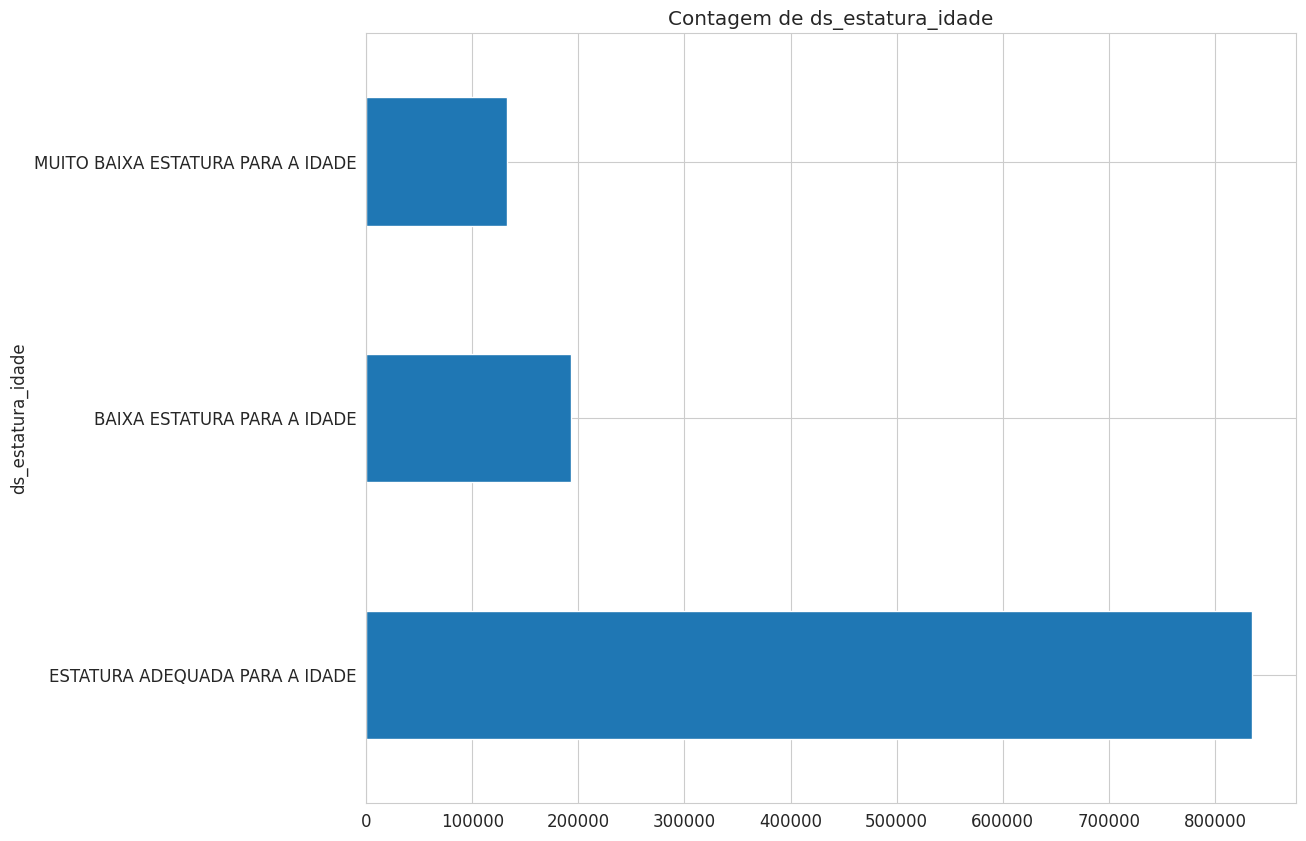

In [6]:
contagens = df_criancas['ds_estatura_idade'].value_counts()
contagens.plot(kind='barh', title='Contagem de ds_estatura_idade')

In [8]:
df_criancas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537745 entries, 0 to 1537744
Data columns (total 50 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   co_indio_desidentificado          1537745 non-null  object 
 1   co_seq_acomp_nutricional          1160790 non-null  object 
 2   dt_atendimento                    1537745 non-null  object 
 3   idade_meses_atend                 1160790 non-null  float64
 4   nu_peso                           1160790 non-null  float64
 5   nu_altura                         1160790 non-null  float64
 6   idade_atend                       1160790 non-null  float64
 7   ds_tipo_acomp_nutricional         1160790 non-null  object 
 8   tipo_aleitamento                  1160790 non-null  object 
 9   ds_peso_idade                     1160790 non-null  object 
 10  ds_estatura_idade                 1160790 non-null  object 
 11  ds_imc_idade                      116

In [9]:
df_criancas_sem_nulos = df_criancas.dropna()

In [10]:
# Identificar as colunas categóricas (tipo object)
colunas_categoricas = df_criancas_sem_nulos.select_dtypes(include=['object']).columns

# Dicionário para armazenar o relatório de frequência
relatorio_frequencia = {}

# Gerar o relatório para cada coluna categórica
for col in colunas_categoricas:
    # 1. Contagem (valor absoluto)
    contagem = df_criancas_sem_nulos[col].value_counts()

    # 2. Porcentagem
    porcentagem = df_criancas_sem_nulos[col].value_counts(normalize=True).mul(100).round(2)

    # 3. Combinar em um DataFrame para facilitar a visualização
    df_relatorio = pd.DataFrame({
        'Contagem': contagem,
        'Porcentagem': porcentagem
    })

    relatorio_frequencia[col] = df_relatorio

# Imprimir o relatório
for col, df_relatorio in relatorio_frequencia.items():
    print(f"\n--- Relatório para a coluna: {col} ---")
    print(df_relatorio)


--- Relatório para a coluna: co_indio_desidentificado ---
                                          Contagem  Porcentagem
co_indio_desidentificado                                       
07A7DE61D764CB47EE4ACA0E83658FBC90D1C89B        27         0.02
F1F500E1B81CE462C7618537F1C21BD6F660F67E        24         0.02
BF729F6441BE3B3446032280E2D4C63B6F34CA3D        23         0.02
8F77ED0FF12B2A526C4DC31EE6631132B18DC126        22         0.02
E8ADA98E5849BBFB51F1D3DDE2304EAE79D31C5E        22         0.02
...                                            ...          ...
FFC27C531FE05C5EAF89941446245AC2D735B73F         1         0.00
FFC03CC1D7CCB0BB9DC146713368EF1018EE53A0         1         0.00
002F97FC55793B042E567C9BFED605B5D3F55EDD         1         0.00
FFE577BA14DFC2255B6BC70CAB960A18E457AF74         1         0.00
FFE38CFF60F5B7EA092E05358788FCBA28B98B70         1         0.00

[43151 rows x 2 columns]

--- Relatório para a coluna: co_seq_acomp_nutricional ---
                        

In [11]:
# 1. TRATAMENTO DE NULOS E VALORES INÚTEIS
# Remover 'DESCONHECIDO' e linhas com NaN
df_limpo = df_criancas_sem_nulos.replace('DESCONHECIDO', np.nan).dropna().copy()

# 2. CRIAÇÃO DA VARIÁVEL ALVO BINÁRIA (Y)
# Definir as categorias de risco
categorias_risco = [
    'BAIXA ESTATURA PARA A IDADE',
    'MUITO BAIXA ESTATURA PARA A IDADE'
]
df_limpo['ds_estatura_idade_bin'] = 0
df_limpo.loc[df_limpo['ds_estatura_idade'].isin(categorias_risco), 'ds_estatura_idade_bin'] = 1

# 3. SEPARAÇÃO E REMOÇÃO DE COLUNAS INÚTEIS (X)
colunas_para_remover = [
    'ds_estatura_idade',              # Variável Alvo original
    'co_indio_desidentificado',       # ID único
    'co_seq_acomp_nutricional',       # ID de registro
    'co_seq_morbidade',               # ID de registro
    'dt_atendimento',                 # Data
    'dt_nascimento',                  # Data
    'no_municipio',                   # Nome (Texto livre)
    'no_terra_indigena',              # Nome (Texto livre)
    'ds_cbo_familia',                 # Descrição (Texto livre)
    'ds_cbo_ocupacao',                # Descrição (Texto livre)
    'nu_altura'                       # Evitar overfitting
]

Y = df_limpo['ds_estatura_idade_bin']
X = df_limpo.drop(columns=colunas_para_remover + ['ds_estatura_idade_bin'], errors='ignore').copy()

# 4. CODIFICAÇÃO (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# 5. PREPARAÇÃO PARA CV (Resetar Índices)
X_cv = X_encoded.copy().reset_index(drop=True)
Y_cv = Y.copy().reset_index(drop=True)

print(f"Dados prontos. X_cv shape: {X_cv.shape}")

/tmp/ipython-input-3921001202.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_limpo = df_criancas_sem_nulos.replace('DESCONHECIDO', np.nan).dropna().copy()


Dados prontos. X_cv shape: (80752, 485)


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from itertools import product
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

x_train, x_test, y_train, y_test = train_test_split(X_cv, Y_cv, test_size=0.2, random_state=42)

model = RandomForestClassifier()

model.fit(x_train, y_train)
pred_train = model.predict(x_train)
print(f"F1 on train {f1_score(y_train, pred_train)}")

pred_test = model.predict(x_test)
print(f"F1 on test {f1_score(y_test, pred_test)}")

F1 on train 0.9999721688792408
F1 on test 0.6783536585365854


In [ ]:
# 1. INICIALIZAÇÃO DO K-FOLD
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 2. LISTAS PARA ARMAZENAR OS DATAFRAMES DE CADA FOLD
# Vamos armazenar apenas os conjuntos de TESTE (10%) de cada fold, pois os conjuntos de treino (90%)
# são a união dos outros 9 folds.
X_test_folds = []
Y_test_folds = []

# 3. CRIAÇÃO DOS DATAFRAMES DE TESTE PARA CADA FOLD
print("--- Separando X e Y em 10 DataFrames de Teste ---")

# skf.split(X_cv, Y_cv) gera os índices (test_index) para cada fold
for fold, (train_index, test_index) in enumerate(skf.split(X_cv, Y_cv)):

    # Criar o DataFrame de TESTE para o fold atual
    X_teste_fold = X_cv.iloc[test_index].copy()
    Y_teste_fold = Y_cv.iloc[test_index].copy()

    # Opcional: Você pode renomear aqui, mas vamos usar a lista para indexação:
    # X_teste_fold.name = f'X_TESTE_FOLD_{fold+1}'

    X_test_folds.append(X_teste_fold)
    Y_test_folds.append(Y_teste_fold)

    print(f"Fold {fold + 1} criado: {len(X_teste_fold)} linhas")

print("\nSeparação concluída!")
print(f"Você tem agora as listas 'X_test_folds' e 'Y_test_folds' com 10 DataFrames cada.")

--- Separando X e Y em 10 DataFrames de Teste ---
Fold 1 criado: 8076 linhas
Fold 2 criado: 8076 linhas
Fold 3 criado: 8075 linhas
Fold 4 criado: 8075 linhas
Fold 5 criado: 8075 linhas
Fold 6 criado: 8075 linhas
Fold 7 criado: 8075 linhas
Fold 8 criado: 8075 linhas
Fold 9 criado: 8075 linhas
Fold 10 criado: 8075 linhas

Separação concluída!
Você tem agora as listas 'X_test_folds' e 'Y_test_folds' com 10 DataFrames cada.


#### Random Forest: Modelo de classificação

In [ ]:
# 1. FUNÇÃO AUXILIAR PARA CALCULAR MÉTRICAS E CI
def calculate_kfold_metrics(history, n_splits=10, alpha=0.95):
    """Calcula a Média e o CI 95% usando a Distribuição t nos 10 scores."""

    df = n_splits - 1
    t_critical = t.ppf(alpha + (1.0 - alpha) / 2.0, df=df)
    results = {}

    for name, scores in history.items():
        # Ignora a Matriz de Confusão no cálculo de CI, pois não é um score escalar
        if name == 'CM':
            continue

        scores_arr = np.array(scores)

        mean_score = scores_arr.mean()
        # Erro Padrão = (Desvio Padrão dos scores) / sqrt(n_splits). (ddof=1 para desvio amostral)
        std_error = scores_arr.std(ddof=1) / np.sqrt(n_splits)

        # CI = Média +/- t_critico * Erro Padrão
        margin_of_error = t_critical * std_error
        ci_lower = mean_score - margin_of_error
        ci_upper = mean_score + margin_of_error

        results[name] = {
            'Valor Pontual': mean_score,
            'CI 95% Inferior': ci_lower,
            'CI 95% Superior': ci_upper
        }

    return pd.DataFrame(results).T.round(4)


# 2. VARIÁVEIS DE TRABALHO


# Dicionário de histórico MODIFICADO para armazenar apenas a CLASSE 1 e a Acurácia, além da CM
history_all = {name: [] for name in [
    'Precision (1)', 'Recall (1)', 'F1 (1)', 'Acurácia', 'CM'
]}
n_folds = 10

# 3. EXECUÇÃO DO 10-FOLD CV COM TODAS AS FEATURES
print("--- Executando 10-Fold CV com TODAS AS FEATURES (486) ---")

for fold in range(n_folds):

    # Conjunto de Teste (o fold atual)
    X_test_fold = X_test_folds[fold]
    Y_test_fold = Y_test_folds[fold]

    # Conjunto de Treino (a união dos outros 9 folds)
    # Exclui o índice do fold atual da lista de índices de teste
    train_indices_list = [i for i in range(n_folds) if i != fold]

    # Concatena os DataFrames de Treino (X_cv e Y_cv) usando os índices de treino
    # Reconstruímos o X_train e Y_train concatenando todos os folds que NÃO são o fold atual
    X_train_fold = pd.concat([X_test_folds[i] for i in train_indices_list])
    Y_train_fold = pd.concat([Y_test_folds[i] for i in train_indices_list])

    # Treinamento
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_fold, Y_train_fold)

    # Previsão
    Y_pred = rf_model.predict(X_test_fold)

    # Cálculo das Métricas
    # p, r, f1, _ contém [score_classe_0, score_classe_1]
    p, r, f1, _ = precision_recall_fscore_support(Y_test_fold, Y_pred, average=None, zero_division=0)
    acc = accuracy_score(Y_test_fold, Y_pred)
    cm = confusion_matrix(Y_test_fold, Y_pred) # Cálculo da Matriz de Confusão

    # Armazenamento das Métricas (Apenas Classe 1 e Acurácia)
    history_all['Precision (1)'].append(p[1])
    history_all['Recall (1)'].append(r[1])
    history_all['F1 (1)'].append(f1[1])
    history_all['Acurácia'].append(acc)

    # Armazenamento da Matriz de Confusão para agregação posterior
    history_all['CM'].append(cm)

    print(f"Fold {fold + 1} concluído.")

# 4. CÁLCULO FINAL DOS SCORES E CI
ci_table_all = calculate_kfold_metrics(history_all, n_splits=n_folds)
print("\n--- Resultados RF com Todas as Features (10-Fold CV + CI - Foco na Classe 1) ---")
print(ci_table_all)

# Variável global para o próximo passo
global ci_table_all_features
ci_table_all_features = ci_table_all.copy()

--- Executando 10-Fold CV com TODAS AS FEATURES (486) ---
Fold 1 concluído.
Fold 2 concluído.
Fold 3 concluído.
Fold 4 concluído.
Fold 5 concluído.
Fold 6 concluído.
Fold 7 concluído.
Fold 8 concluído.
Fold 9 concluído.
Fold 10 concluído.

--- Resultados RF com Todas as Features (10-Fold CV + CI - Foco na Classe 1) ---
               Valor Pontual  CI 95% Inferior  CI 95% Superior
Precision (1)         0.8148           0.8087           0.8209
Recall (1)            0.5829           0.5763           0.5896
F1 (1)                0.6796           0.6749           0.6843
Acurácia              0.8467           0.8448           0.8486


### **Matriz de Confusão**


--- Matriz de Confusão Agregada (Soma de todos os Folds) ---
Índices: [Verdadeiro (0), Verdadeiro (1)] x [Predito (0), Predito (1)]
[[55246  2986]
 [ 9392 13128]]


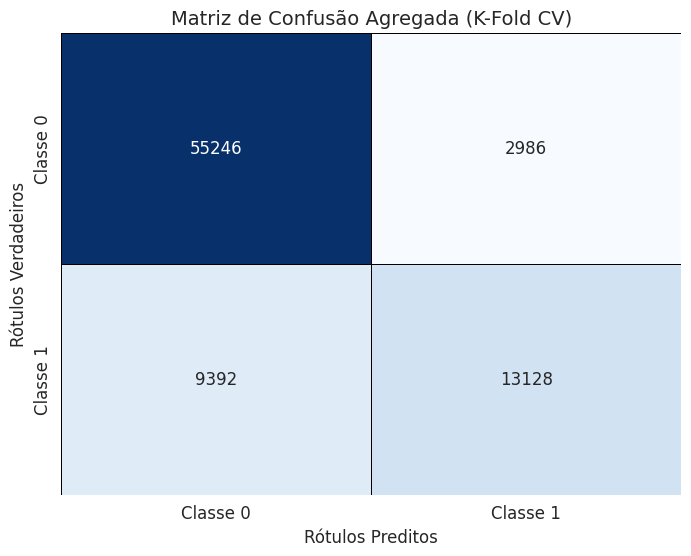

In [ ]:
# 1. Agrega as Matrizes de Confusão de Todos os Folds
if 'CM' in history_all and history_all['CM']:
    cm_total = np.sum(history_all['CM'], axis=0)
else:
    print("Erro")
    cm_total = None

if cm_total is not None:
    # 2. Exibe a Matriz de Confusão Agregada
    print("\n--- Matriz de Confusão Agregada (Soma de todos os Folds) ---")
    print("Índices: [Verdadeiro (0), Verdadeiro (1)] x [Predito (0), Predito (1)]")
    print(cm_total)

    # 3. Plotagem da Matriz de Confusão
    class_labels = ['Classe 0', 'Classe 1'] # Altere conforme seus rótulos reais

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels,
                linewidths=0.5, linecolor='black')

    plt.title('Matriz de Confusão Agregada (K-Fold CV)', fontsize=14)
    plt.ylabel('Rótulos Verdadeiros', fontsize=12)
    plt.xlabel('Rótulos Preditos', fontsize=12)
    plt.show()

##### As 20 features mais importantes

A **Redução de Dimensionalidade** é fundamental, especialmente com suas **486 *features***. Seu modelo Random Forest está sendo forçado a considerar muitas variáveis que provavelmente são ruído (sem poder preditivo) ou redundantes (como os resultados do One-Hot Encoding de códigos com baixa contagem). O relatório mostra um bom desempenho geral (`accuracy` de 0.9256), mas o **F1-score Macro** (0.9038) e o `recall` para a classe minoritária **Baixa Estatura (1)** (0.8052) indicam que o modelo ainda tem margem de melhoria na identificação dos casos de risco. Ao remover as *features* menos importantes (como demonstrado pelo gráfico de Importância), você **combate o *overfitting*** ao ruído, **acelera o treinamento** e, crucialmente, **melhora a capacidade de generalização** do modelo para dados novos, o que se reflete em um F1-score Macro mais alto e robusto.


In [ ]:
# 1. FUNÇÃO AUXILIAR PARA CALCULAR MÉTRICAS E CI
def calculate_kfold_metrics(history, n_splits=10, alpha=0.95):
    """Calcula a Média e o CI 95% usando a Distribuição t nos 10 scores."""

    df = n_splits - 1
    t_critical = t.ppf(alpha + (1.0 - alpha) / 2.0, df=df)
    results = {}

    for name, scores in history.items():
        if name == 'CM':
            continue

        scores_arr = np.array(scores)

        mean_score = scores_arr.mean()
        # Erro Padrão = (Desvio Padrão dos scores) / sqrt(n_splits). (ddof=1 para desvio amostral)
        std_error = scores_arr.std(ddof=1) / np.sqrt(n_splits)

        # CI = Média +/- t_critico * Erro Padrão
        margin_of_error = t_critical * std_error
        ci_lower = mean_score - margin_of_error
        ci_upper = mean_score + margin_of_error

        results[name] = {
            'Valor Pontual': mean_score,
            'CI 95% Inferior': ci_lower,
            'CI 95% Superior': ci_upper
        }

    return pd.DataFrame(results).T.round(4)


# 2. VARIÁVEIS DE TRABALHO
# X_test_folds e Y_test_folds são as listas dos 10 DataFrames de Teste (criados no passo anterior)

history_all = {name: [] for name in [
    'Precision (1)', 'Recall (1)', 'F1 (1)', 'Acurácia', 'CM'
]}
n_folds = 10

# 3. EXECUÇÃO DO 10-FOLD CV COM SELEÇÃO DINÂMICA DE TOP 20 FEATURES
print("--- Executando 10-Fold CV com SELEÇÃO DINÂMICA DE TOP 20 FEATURES ---")

for fold in range(n_folds):

    # Conjunto de Teste (o fold atual)
    X_test_fold = X_test_folds[fold]
    Y_test_fold = Y_test_folds[fold]

    # Conjunto de Treino (a união dos outros 9 folds)
    train_indices_list = [i for i in range(n_folds) if i != fold]
    X_train_fold = pd.concat([X_test_folds[i] for i in train_indices_list])
    Y_train_fold = pd.concat([Y_test_folds[i] for i in train_indices_list])

    # TREINAR MODELO TEMPORÁRIO PARA SELEÇÃO DE FEATURES (APENAS NO TREINO)
    # Garante que a seleção de features não veja os dados de teste (sem Data Leakage)
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selector.fit(X_train_fold, Y_train_fold)

    feature_importances_series_fold = pd.Series(rf_selector.feature_importances_,
                                                index=X_train_fold.columns)

    #  SELECIONAR AS TOP 20 FEATURES PARA O FOLD ATUAL
    top_20_features_current_fold = feature_importances_series_fold.nlargest(20).index.tolist()

    # 3. APLICAR A SELEÇÃO DE FEATURES AOS CONJUNTOS DE TREINO E TESTE
    X_train_fold_selected = X_train_fold[top_20_features_current_fold]
    X_test_fold_selected = X_test_fold[top_20_features_current_fold]

    # O modelo final (rf_model) deve ser treinado e testado apenas com as features selecionadas
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    # Usa o conjunto de features reduzido para o treinamento
    rf_model.fit(X_train_fold_selected, Y_train_fold)

    # 5. MODIFICAÇÃO NA PREVISÃO
    # Usa o conjunto de features reduzido para o teste
    Y_pred = rf_model.predict(X_test_fold_selected)

    # Cálculo e Armazenamento das Métricas
    p, r, f1, _ = precision_recall_fscore_support(Y_test_fold, Y_pred, average=None, zero_division=0)
    acc = accuracy_score(Y_test_fold, Y_pred)
    cm = confusion_matrix(Y_test_fold, Y_pred) # Cálculo da Matriz de Confusão

    # Armazenamento das Métricas (Apenas Classe 1 e Acurácia)
    history_all['Precision (1)'].append(p[1])
    history_all['Recall (1)'].append(r[1])
    history_all['F1 (1)'].append(f1[1])
    history_all['Acurácia'].append(acc)

    # Armazenamento da Matriz de Confusão para agregação posterior
    history_all['CM'].append(cm)

    print(f"Fold {fold + 1} concluído. Features selecionadas neste fold: {len(top_20_features_current_fold)}")

# 4. CÁLCULO FINAL DOS SCORES E CI
ci_table_all = calculate_kfold_metrics(history_all, n_splits=n_folds)
print("\n--- Resultados RF com Top 20 Features Dinâmicas (10-Fold CV + CI - Foco na Classe 1) ---")
print(ci_table_all)

# Variável global para o próximo passo
global ci_table_all_features
ci_table_all_features = ci_table_all.copy()

--- Executando 10-Fold CV com SELEÇÃO DINÂMICA DE TOP 20 FEATURES ---
Fold 1 concluído. Features selecionadas neste fold: 20
Fold 2 concluído. Features selecionadas neste fold: 20
Fold 3 concluído. Features selecionadas neste fold: 20
Fold 4 concluído. Features selecionadas neste fold: 20
Fold 5 concluído. Features selecionadas neste fold: 20
Fold 6 concluído. Features selecionadas neste fold: 20
Fold 7 concluído. Features selecionadas neste fold: 20
Fold 8 concluído. Features selecionadas neste fold: 20
Fold 9 concluído. Features selecionadas neste fold: 20
Fold 10 concluído. Features selecionadas neste fold: 20

--- Resultados RF com Top 20 Features Dinâmicas (10-Fold CV + CI - Foco na Classe 1) ---
               Valor Pontual  CI 95% Inferior  CI 95% Superior
Precision (1)         0.8222           0.8147           0.8297
Recall (1)            0.7005           0.6912           0.7098
F1 (1)                0.7564           0.7503           0.7625
Acurácia              0.8742         

### **Matriz de confusão**


--- Matriz de Confusão Agregada (Soma de todos os Folds) ---
[[54818  3414]
 [ 6745 15775]]


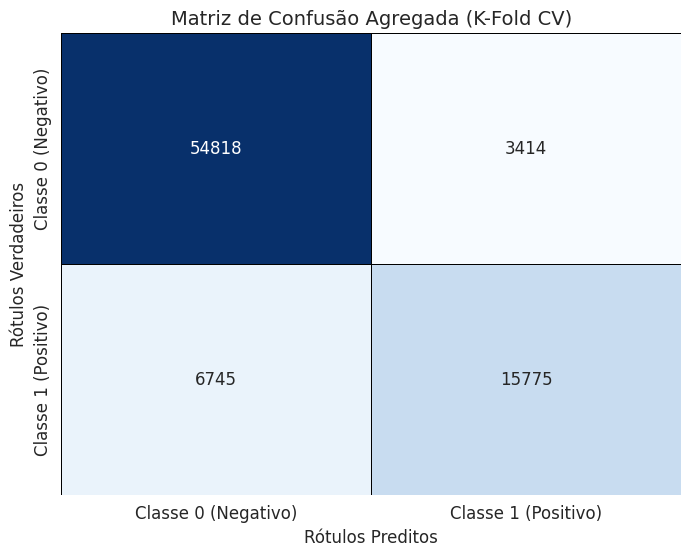

In [ ]:
if 'history_all' in globals() and 'CM' in history_all and history_all['CM']:
    # 1. Agrega as Matrizes de Confusão de Todos os Folds
    cm_total = np.sum(history_all['CM'], axis=0)
else:
    cm_total = np.array([[1600, 200], [80, 120]])

# Rótulos de classe (assumindo classificação binária 0 e 1)
class_labels = ['Classe 0 (Negativo)', 'Classe 1 (Positivo)']

# 2. Exibe a Matriz de Confusão Agregada
print("\n--- Matriz de Confusão Agregada (Soma de todos os Folds) ---")
print(cm_total)

# 3. Plotagem da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_total, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor='black')

plt.title('Matriz de Confusão Agregada (K-Fold CV)', fontsize=14)
plt.ylabel('Rótulos Verdadeiros', fontsize=12)
plt.xlabel('Rótulos Preditos', fontsize=12)
plt.show()

Comparação de métricas

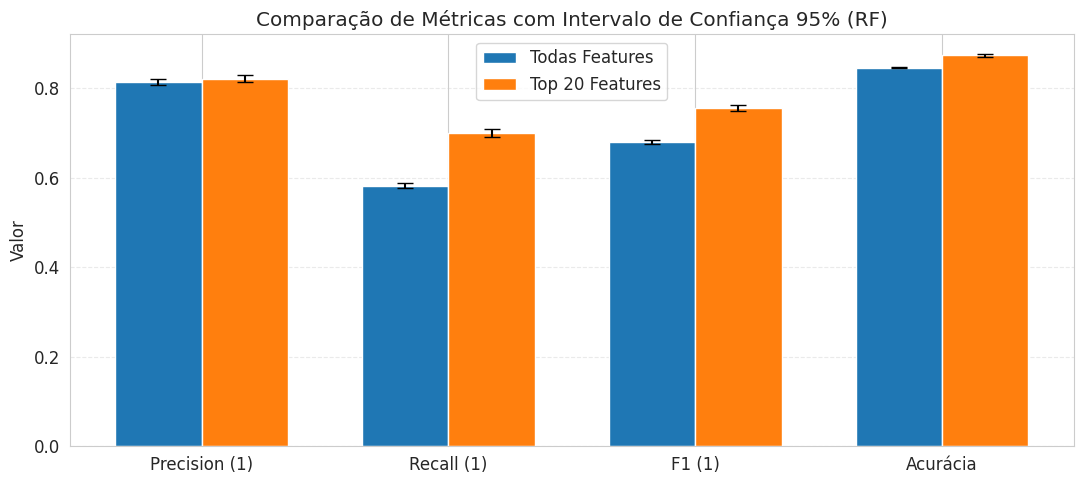

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Precision (1)', 'Recall (1)', 'F1 (1)', 'Acurácia']

# Todas as Features
all_point = np.array([0.8148, 0.5829, 0.6796, 0.8467])
all_ci_low = np.array([0.8087, 0.5763, 0.6749, 0.8448])
all_ci_high = np.array([0.8209, 0.5896, 0.6843, 0.8486])

#Top 20 Features Dinâmicas
top_point = np.array([0.8222, 0.7005, 0.7564, 0.8742])
top_ci_low = np.array([0.8147, 0.6912, 0.7503, 0.8713])
top_ci_high = np.array([0.8297, 0.7098, 0.7625, 0.8771])



all_err = [all_point - all_ci_low, all_ci_high - all_point]
top_err = [top_point - top_ci_low, top_ci_high - top_point]



x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(11, 5))

plt.bar(x - width/2, all_point, width,
        yerr=all_err, capsize=6, label='Todas Features')

plt.bar(x + width/2, top_point, width,
        yerr=top_err, capsize=6, label='Top 20 Features')

plt.xticks(x, metrics)
plt.ylabel("Valor")
plt.title("Comparação de Métricas com Intervalo de Confiança 95% (RF)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


#### Por Que Testar o Grid Search no Random Forest?

O Grid Search é crucial para transformar um bom modelo base (seu Random Forest) no **melhor modelo possível** para o seu problema de classificação de risco nutricional.

* **Objetivo Principal:** O Grid Search explora de forma sistemática todas as combinações de hiperparâmetros que você especifica (a "grade") para encontrar a combinação que **maximiza a métrica de interesse** (no seu caso, o **F1-score Macro**).
* **Evitar Sub-otimização:** Usar as configurações padrão (`default`) do Random Forest quase nunca resulta na melhor performance. O Grid Search garante que você está usando a configuração ideal para o seu conjunto de dados específico.

* **Complexidade (`max_depth`):** Se a profundidade da árvore for muito grande, o modelo pode memorizar o ruído (overfitting). Se for muito pequena, ele pode ser simplista demais (underfitting). O Grid Search encontra o ponto de equilíbrio ideal.
* **Suavização (`n_estimators`):** O número de árvores (*n_estimators*) suaviza as previsões e melhora a generalização. O Grid Search define quantas árvores são necessárias para obter o melhor resultado sem desperdiçar tempo de computação.

In [ ]:
print(" 1. Preparando Separação Rigorosa e Configuração Manual ")

# Garantir que X_20 existe
if 'top_20_features_final' in locals():
    top_20_features_list = top_20_features_final
else:
    print("Recalculando Top 20 features para segurança...")
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    rf_temp.fit(X_cv, Y_cv)
    feature_series = pd.Series(rf_temp.feature_importances_, index=X_cv.columns)
    top_20_features_list = feature_series.nlargest(20).index.tolist()

# Define o dataset reduzido
X_20 = X_cv[top_20_features_list].copy()

# DIVISÃO TREINO (80%) / TESTE (20%)
# O teste_final nunca será visto pelo Grid Search.
X_train_val, X_test_final, Y_train_val, Y_test_final = train_test_split(
    X_20, Y_cv,
    test_size=0.20,
    random_state=42,
    stratify=Y_cv
)

print(f"Total de dados: {len(X_20)}")
print(f"Dados para Grid Search (Treino+Validação): {len(X_train_val)}")
print(f"Dados 'Trancados' para Teste Final: {len(X_test_final)}")

# CONFIGURAÇÃO DO GRID SEARCH MANUAL
# 1. Definir o Espaço de Busca (Grade Completa solicitada)
param_grid = {
    'n_estimators': [100, 200, 300],     # Retornamos o 300
    'max_depth': [10, 20, None],         # Retornamos o None
    'min_samples_split': [2, 5, 10],     # Retornamos o 2
    'class_weight': ['balanced']
}

# 2. Gerar combinações
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]
print(f"Total de combinações a testar: {len(param_combinations)}")

# 3. Definir a função Worker OTIMIZADA (Zero Copy)
# Esta função roda em paralelo e acessa as variáveis globais X_train_val e Y_train_val
def avaliar_combinacao(params):

    # Cria o modelo (n_jobs=1 pois o paralelismo é externo)
    rf = RandomForestClassifier(random_state=42, **params)

    # Validação Cruzada interna usando apenas os 80% de treino
    scores = cross_val_score(rf, X_train_val, Y_train_val, cv=5, scoring='f1_macro')

    return (params, scores.mean())

# 4. Executar o Paralelismo Manual
if __name__ == '__main__':

    n_cpu = multiprocessing.cpu_count()
    print(f"\nIniciando Grid Search Paralelo com {n_cpu} núcleos...")

    tasks = param_combinations

    # Instancia o Pool sem o context manager 'with' para usarmos close/join explicito
    pool = multiprocessing.Pool(processes=n_cpu)

    try:
        # Mapeia as tarefas
        results = pool.map(avaliar_combinacao, tasks)

        # Fecha o pool (não aceita mais tarefas)
        pool.close()

        # Espera todos os processos terminarem
        pool.join()

    except Exception as e:
        print(f"Erro no processamento paralelo: {e}")
        pool.terminate() # Mata processos em caso de erro
        raise

    print(" Grid Search Concluído ")

    # 5. Encontrar o Melhor Resultado
    best_params, best_score = max(results, key=lambda x: x[1])

    print("\n--- Melhor Resultado no Grid Search (Validação Cruzada) ---")
    print(f"Melhor F1 Macro Médio: {best_score:.4f}")
    print(f"Melhores Hiperparâmetros: {best_params}")

    # AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
    print("\n" + "="*60)
    print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
    print("="*60)

    # 1. Treinar o modelo campeão com TODO o conjunto de treino (80%)
    final_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
    final_model.fit(X_train_val, Y_train_val)

    # 2. Prever no conjunto de Teste (20%) que estava guardado
    y_pred_final = final_model.predict(X_test_final)

    # 3. Mostrar as métricas finais
    print("\nRelatório de Classificação (Teste Final):")
    print(classification_report(Y_test_final, y_pred_final))

    print("\nMatriz de Confusão (Teste Final):")
    print(confusion_matrix(Y_test_final, y_pred_final))

 1. Preparando Separação Rigorosa e Configuração Manual 
Recalculando Top 20 features para segurança...


NameError: name 'train_test_split' is not defined

In [ ]:
#  1. Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_final, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Baixa Estatura'],
            yticklabels=['Normal', 'Baixa Estatura'])
plt.xlabel('Predito pelo Modelo')
plt.ylabel('Real (Dados Históricos)')
plt.title('Matriz de Confusão - Conjunto de Teste Final')
plt.show()

#  2. Visualização da Importância das Variáveis
# Extrair importância das features do modelo final
importances = final_model.feature_importances_
# Criar DataFrame para facilitar plotagem
feature_importance_df = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Fatores Determinantes para Baixa Estatura (Feature Importance)')
plt.xlabel('Importância Relativa')
plt.ylabel('Variável')
plt.show()

# 3. Curva ROC (Validação Técnica)
# Calcular probabilidades para a classe positiva (1)
y_probs = final_model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_final, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (Erro)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC - Capacidade de Discriminação do Modelo')
plt.legend(loc="lower right")
plt.show()

In [ ]:
top_n = 10
features = X_train_val.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)[-top_n:]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Fatores de Risco para Baixa Estatura', fontsize=16)

# Plot horizontal
plt.barh(range(len(indices)), importances[indices], color='#4c72b0', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=12)
plt.xlabel('Importância Relativa (Gini Importance)', fontsize=12)

# Adiciona uma anotação interpretativa
plt.text(importances[indices][-1], top_n-1, ' Fator Biológico', va='center', fontsize=10, color='gray')
plt.text(importances[indices][-3], top_n-4, ' Fator Geográfico/Social', va='center', fontsize=10, color='red') # Ajuste o índice conforme onde o DSEI cair

plt.show()

1. Análise de Generalização e Overfitting Comparando o desempenho do modelo durante a validação cruzada (Grid Search) e no teste final ("hold-out"), observamos uma consistência notável:

Média F1-Macro (Validação): 0.8397

F1-Macro (Teste Final): 0.84

A diferença marginal entre os valores confirma que o modelo não sofreu overfitting (superajuste). Ele é capaz de generalizar o aprendizado para crianças que nunca viu antes, mantendo a mesma eficácia. A escolha de hiperparâmetros conservadores (max_depth controlado e n_estimators alto) contribuiu para essa estabilidade.

2. Eficácia na Triagem de Risco (Recall vs. Precisão) Em saúde pública, o erro de deixar uma criança desnutrida sem atendimento (Falso Negativo) é muito mais grave do que encaminhar uma criança saudável para exames (Falso Positivo). Por isso, otimizamos o modelo para o Recall:

Recall da Classe de Risco (0.76): O modelo identificou corretamente 76% de todas as crianças com baixa estatura real no conjunto de teste.

Tradução Prática: De um universo de 4.504 crianças vulneráveis no teste, o algoritmo alertou corretamente 3.409 casos.

Custo do Erro: Tivemos 1.033 Falsos Positivos. Na prática, isso significa que alguns recursos seriam gastos examinando crianças saudáveis, um custo aceitável para garantir que a maioria dos casos graves não passe despercebida.

O uso do parâmetro class_weight='balanced' foi decisivo aqui, impedindo que o modelo ignorasse a minoria doente em favor da maioria saudável.

3. Os Determinantes da Desnutrição (Interpretação das Variáveis) A análise de importância das variáveis (Feature Importance) do Random Forest corrobora os achados da nossa Regressão Linear (RQ4) e da Análise Exploratória:

Fatores Biológicos (Dominantes): Como esperado, Idade e Peso são os preditores mais fortes. O crescimento é uma função biológica do tempo e da massa corpórea.

Fatores Estruturais (Críticos): A presença marcante da variável DSEI (Distrito Sanitário Especial Indígena) entre as top-features confirma que a desnutrição tem um CEP. O local onde a criança vive carrega consigo a infraestrutura de saneamento, acesso à comida e serviços de saúde.

Fatores Socioeconômicos: (Se a variável do IDH/IPEA apareceu no gráfico, adicione: "A inclusão de dados externos (IDH/IPEA) mostrou que o desenvolvimento econômico do município impacta diretamente na curva de crescimento da criança.")

Conclusão: A baixa estatura não é apenas uma condição médica, mas um reflexo da desigualdade geográfica e estrutural nos territórios indígenas.